In [5]:
from icecube import icetray, dataio, dataclasses, simclasses, clsim
from icecube.icetray import I3Units, OMKey, I3Frame
from icecube.dataclasses import ModuleKey
from os.path import expandvars
import scipy.constants as spc
import scipy as sc
import numpy as np
import matplotlib.pylab as plt
import argparse
from scipy import stats
from scipy.optimize import minimize
from scipy.stats.distributions import chi2

import scipy

'''
Inputs
'''
#parser = argparse.ArgumentParser(description = "Takes I3Photons from step2 of the simulations and generates DOM hits")
#parser.add_argument('-i', '--infile', dest = 'infile', help= 'input file and path')
#parser.add_argument('-o', '--outfile', dest = 'outfile', help= 'output file and path')
#args = parser.parse_args()

infile = '/data/p-one/akatil/step_4_medium_water/NuTau_NuE_20Events/step_4_'+str(713)+'_medium_water_custom_mDOM_noise.i3.gz'

In [13]:
'''
Functions
'''

def gaussian(x, pos, wid, amp):
    y = amp*np.exp(-4*np.log(2)*((x-pos)/(wid))**2)
    return y

def biGauss(x, pos, wid, r, amp):
    mask = x < pos

    y_all = ([])
    for i in range(0, len(mask)):

        if mask[i] == True:
            m = 1
            nm = 0
        else:
            m = 0
            nm = 1
        if r != 0:
            y1 = gaussian(x[i],pos,r*wid/(r+1),amp)*m
            y2 = gaussian(x[i],pos,wid/(r+1),amp)*nm
            y = y1 + y2
        else:
            y = gaussian(x[i],pos,wid, amp)*nm

        y_all = np.append(y_all, y)
    return y_all

def double_peak(x, pos1, wid1, r1, amp1, pos2, wid2, r2, amp2):
    b1 = biGauss(x, pos1, wid1, r1, amp1)
    b2 = biGauss(x, pos2, wid2, r2, amp2)
    b = np.append(b1, b2)
    return b1+b2

def log_likelihood_biGauss(theta, n, x):
    pos, wid, r, amp = theta
    model = biGauss(x, pos, wid, r, amp)
    L = model - (n*np.log(model))
    return np.sum(L)

def log_likelihood_doublePeak(theta, n, x):
    pos1, wid1, r1, amp1, pos2, wid2, r2, amp2 = theta
    model = double_peak(x, pos1, wid1, r1, amp1, pos2, wid2, r2, amp2)
    L = model - (n*np.log(model))
    return np.sum(L)

def likelihood_ratio_doublePeak(x, n, pos1, wid1, r1, amp1, pos2, wid2, r2, amp2):
    model = double_peak(x, pos1, wid1, r1, amp1, pos2, wid2, r2, amp2)
    val = model - n + (n*np.log(n/model))
    #print('log - ', n/model, 'n - ', n)
    return np.sum(val)

def likelihood_ratio_biGauss(x, n, pos, wid, r, amp):
    model = biGauss(x, pos, wid, r, amp)
    val = model - n + (n*np.log(n/model))
    #print('log - ', n/model, 'n - ', n)
    return np.sum(val)

In [7]:
gcd_file = dataio.I3File('/home/users/akatil/P-ONE/GCD_files/PONE_Phase1.i3.gz')
cframe = gcd_file.pop_frame()
geometry = cframe["I3Geometry"]
omgeo = geometry.omgeo
print('loaded geometry')

loaded geometry


In [42]:
def likelihoodfit():

    print('LikelihoodFit')
    tau_timeDiff = ([])
    tau_pVal = ([])
    tau_LRR = ([])
    tau_wid1_ratio = ([])
    tau_wid2_ratio = ([])
    tau_amp1_ratio = ([])
    tau_amp2_ratio = ([])

    e_timeDiff = ([])
    e_pVal = ([])
    e_LRR = ([])
    e_wid1_ratio = ([])
    e_wid2_ratio = ([])
    e_amp1_ratio = ([])
    e_amp2_ratio = ([])

    tau_wid_ratio_dp = ([])
    e_wid_ratio_dp = ([])
    tau_amp_ratio_dp = ([])
    e_amp_ratio_dp = ([])

    #print('FILE NUMBER - ', str(args.infile))
    #file = dataio.I3File('/data/p-one/akatil/step_4_medium_water/NuTau_NuE_20Events/step_4_'+str(i)+'_medium_water_custom_mDOM_noise.i3.gz')
    file = dataio.I3File(str(infile))

    f = 1

    #txt_file = open("/data/p-one/akatil/analysis/25_30/files_greater_than_100.txt", "a")

    for frame in file:
        #print('frame num - ', f)
        mctree = frame["I3MCTree"]
        primary = mctree.primaries
        lepton = dataclasses.I3MCTree.first_child(mctree, primary[0].id)

        mcpeMap = frame['MCPESeriesMap']
        noiseMap = frame['NoiseSeriesMap']

        for omkey in mcpeMap.keys():
            oKey = omgeo.get(omkey)

            '''
            Obtaining the timeList
            '''
            noise_mcpeList = noiseMap[omkey]
            noise_timeList = np.array([mcpe.time for mcpe in noise_mcpeList])
            mcpeList = mcpeMap[omkey]
            timeList = np.array([mcpe.time for mcpe in mcpeList])
            tot_timeList = np.append(timeList, noise_timeList)


            '''
            Removing DOMs with hits less than 250 Hits
            '''
            if len(tot_timeList) < 250:
                continue


            '''
            Calculating the mean and removing the tails
            '''

            timeList = timeList[timeList < min(timeList)+30]

            mean_physicsHits = timeList.mean()
            mean_tot = tot_timeList.mean()

            select_time = tot_timeList[(tot_timeList > mean_tot-50) & (tot_timeList < mean_tot+50)]
            new_mean = select_time.mean()

            bins = np.arange(min(select_time), max(select_time), 1)
            max_hitTimes = select_time[(select_time > (new_mean-40))&(select_time < (new_mean+40))]

            z = stats.zscore(max_hitTimes)

            #using zscore to remove the effect of outliers from the analysis]
            max_hitTimes = max_hitTimes[(z>-1.6)&(z < 1.2)]
            new_mean = max_hitTimes.mean()
            timestamps = max_hitTimes - new_mean
            final_mean = timestamps.mean()

            num_photons = len(max_hitTimes[max_hitTimes>0])

            if len(max_hitTimes) < 250:
                continue

            #if np.log10(num_photons) >= 3.0 or np.log10(num_photons) < 2.5:
                #continue

            '''
            Histogramming the data from simulation
            '''

            bins = np.arange(min(timestamps), max(timestamps), 1)
            num, bin_edges = np.histogram(timestamps, bins=bins)
            bin_centers = (bin_edges[:-1]+bin_edges[1:])/2

            #print('LOG LIKELIHOOD')

            '''
            Removing DOMs that don't have less than 8 non zero bins
            '''
            if len(num[num>0]) <= 8:
                continue



            '''
            Fitting bifurcated Gaussian and double bifurcated gaussian to the mcpe hit time distributions
            for both tau and electron.
            '''
            
            nll = lambda *args: log_likelihood_biGauss(*args)
            initial_biGauss = np.array([final_mean, 50, 5, max(num)])
            #bnds_biGauss = ((min(bin_centers), mean_timeArrival), (0, 20), (0, 2), (0, max(num)), (mean_timeArrival, max(bin_centers)), (0, 20), (0, 2), (0, max(num)))

            #print(len(num), len(initial_biGauss), initial_biGauss)
            bnds_biGauss = ((min(bin_centers), max(bin_centers)), (0, 100), (0, 10), (0, 1e6))
            print('----------BOUNDS-----------')
            print(bnds_biGauss)
            soln_biGauss = minimize(log_likelihood_biGauss, initial_biGauss, args=(num, bin_centers),
                                    method='Powell', bounds = bnds_biGauss)

            nll = lambda *args: log_likelihood_doublePeak(*args)
            initial_doublePeak = np.array([min(bin_centers)+10, 20, 1, max(num), final_mean, 20, 1, max(num)])
            bnds_doublePeak = ((min(bin_centers), final_mean), (0, 100), (0, 10), (0, 1e6),
                               (final_mean, max(bin_centers)), (0, 100), (0, 10), (0,1e6))
            soln_doublePeak = minimize(log_likelihood_doublePeak, initial_doublePeak, args=(num, bin_centers),
                                    method='Powell',bounds=bnds_doublePeak)
                
            '''
            Removing DOMs whose minimization is not successful
            '''
            #if soln_biGauss.success == False or soln_doublePeak.success == False:
                #print('Removing DOMs whose minimization is not successful')
                #continue

            '''
            Calculating the Likelihood ratio for bifurcated gaussian and double double bifurcated gaussian
            '''
            LR_biGauss = likelihood_ratio_biGauss(bin_centers[num>0], num[num>0], soln_biGauss.x[0],
                                             soln_biGauss.x[1], soln_biGauss.x[2], soln_biGauss.x[3])
            LR_doublePeak = likelihood_ratio_doublePeak(bin_centers[num>0], num[num>0], soln_doublePeak.x[0], soln_doublePeak.x[1],
                                             soln_doublePeak.x[2], soln_doublePeak.x[3], soln_doublePeak.x[4],
                                             soln_doublePeak.x[5], soln_doublePeak.x[6], soln_doublePeak.x[7])
            


            '''
            Calculating the p-value using the likelihood ratio
            '''
            pVal_biGauss = chi2.sf(LR_biGauss, len(num) - 4)
            pVal_doublePeak = chi2.sf(LR_doublePeak, len(num) - 8)

            if pVal_biGauss != pVal_biGauss:
                print('BiGauss is not well defined - ', str(lepton.type))
                print('Minimisation - ', soln_biGauss.success)
                print('Degrees of Freedom - ', len(num) - 4)
                print('Log Likelihood - ', LR_biGauss)
            if pVal_doublePeak != pVal_doublePeak:
                print('double peak is not well defined - ', str(lepton.type))
                print('Minimisation - ', soln_doublePeak.success)
                print('Degrees of Freedom - ', len(num) - 8)
                print('Log Likelihood - ', LR_doublePeak)

            '''
            (x, y) values for the fit
            '''
            x = np.linspace(min(bin_centers), max(bin_centers), 1000)
            #x = np.linspace(0, max(bin_centers)+1e5, 1000)
            y_biGauss = biGauss(x, soln_biGauss.x[0],
                                            soln_biGauss.x[1], soln_biGauss.x[2], soln_biGauss.x[3])
            y_doublePeak = double_peak(x, soln_doublePeak.x[0], soln_doublePeak.x[1],
                                            soln_doublePeak.x[2], soln_doublePeak.x[3], soln_doublePeak.x[4],
                                            soln_doublePeak.x[5], soln_doublePeak.x[6], soln_doublePeak.x[7])

            '''
            Calculating the time difference and p-value ratio of bigauss and double peak
            '''
            timeDifference_doublePeak = soln_doublePeak.x[4] - soln_doublePeak.x[0]
            pVal_ratio = pVal_doublePeak/pVal_biGauss
            LRR = LR_doublePeak/LR_biGauss
            wid1_ratio = soln_doublePeak.x[1]/soln_biGauss.x[1]
            wid2_ratio = soln_doublePeak.x[5]/soln_biGauss.x[1]
            amp1_ratio = soln_doublePeak.x[3]/soln_biGauss.x[3]
            amp2_ratio = soln_doublePeak.x[7]/soln_biGauss.x[3]
            wid1_wid2 = soln_doublePeak.x[1]/soln_doublePeak.x[5]
            amp1_amp2 = soln_doublePeak.x[3]/soln_doublePeak.x[7]



            '''
            Removing terrible fits
            '''
            if abs(timeDifference_doublePeak) > 100:
                #print('*****----------timeDifference > 100----------********')
                #print(abs(LR_biGauss-LR_doublePeak))
                #print(str(args.infile)+'----->', timeDifference_doublePeak)
                #txt_file.write('File - '+str(args.infile)+' - Frame Number - '+str(f)+' - OMKey - '+str(omkey)+ ' - Time Difference - '+str(timeDifference_doublePeak)+'-\n')
                #continue
                
                plt.figure(figsize=(10,9))
                _ = plt.hist(timestamps, bins=bins, histtype='step')
                plt.title(str(lepton.type)+' timeDifference > 100 ' + str(abs(LR_biGauss/LR_doublePeak)))
                plt.plot(x, y_biGauss, '--', c = 'r')
                plt.plot(x, y_doublePeak, '--', c = 'k')
                plt.axvline(final_mean, c = 'b')
                
            else:
                #print('*****----------timeDifference < 100----------********')
                #print(abs(LR_biGauss-LR_doublePeak))
                
                plt.figure(figsize=(10,9))
                _ = plt.hist(timestamps, bins=bins, histtype='step')
                plt.title(str(lepton.type)+' timeDifference < 100 '+ str(abs(LR_biGauss/LR_doublePeak)))
                plt.plot(x, y_biGauss, '--', c = 'r')
                plt.plot(x, y_doublePeak, '--', c = 'k')
                plt.axvline(final_mean, c = 'b')

            amp1 = soln_doublePeak.x[3]
            amp2 = soln_doublePeak.x[7]
            if amp1/amp2 < 1/4 and amp1/amp2 > 4:
                print('Removing terrible fits')
                continue

            if amp1 < 0 or amp2 < 0:
                print('Error in amp')
                '''
                plot mcpe time distributions obtained using simulations and the fits
                '''
                plt.figure(figsize=(10,9))
                _ = plt.hist(timestamps, bins=bins, histtype='step')
                plt.title(str(lepton.type)+' ERROR IN AMP')
                #plt.plot(x, y_biGauss, '--', c = 'r')
                #plt.plot(x, y_doublePeak, '--', c = 'k')
                plt.axvline(final_mean, c = 'b')
                
                print(soln_doublePeak, soln_biGauss)


                continue

            print('Reached Here')


            '''
            plot mcpe time distributions obtained using simulations and the fits
            '''
            #plt.figure(figsize=(10,9))
            #_ = plt.hist(timestamps, bins=bins, histtype='step')
            #plt.title(str(lepton.type))
            #plt.plot(x, y_biGauss, '--', c = 'r')
            #plt.plot(x, y_doublePeak, '--', c = 'k')
            #plt.axvline(final_mean, c = 'b')


            '''
            Separating the time difference calculated above and appending the values
            '''

            '''
            Tau
            '''
            if lepton.type == 15 or lepton.type == -15:
                tau_timeDiff = np.append(tau_timeDiff, timeDifference_doublePeak)
                tau_pVal = np.append(tau_pVal, pVal_ratio)
                tau_LRR = np.append(tau_LRR, LRR)
                tau_wid1_ratio = np.append(tau_wid1_ratio, wid1_ratio)
                tau_wid2_ratio = np.append(tau_wid2_ratio, wid2_ratio)
                tau_amp1_ratio = np.append(tau_amp1_ratio, amp1_ratio)
                tau_amp2_ratio = np.append(tau_amp2_ratio, amp2_ratio)

                tau_wid_ratio_dp = np.append(tau_wid_ratio_dp, wid1_wid2)
                tau_amp_ratio_dp = np.append(tau_amp_ratio_dp, amp1_amp2)
                #plt.title('E')

            '''
            Electron and Neutral Current
            '''

            if lepton.type == 11 or lepton.type == -11 or lepton.type == 12 or lepton.type == -12 or lepton.type == 16 or lepton.type == -16:

                e_timeDiff = np.append(e_timeDiff, timeDifference_doublePeak)
                e_pVal = np.append(e_pVal, pVal_ratio)
                e_LRR = np.append(e_LRR, LRR)
                e_wid1_ratio = np.append(e_wid1_ratio, wid1_ratio)
                e_wid2_ratio = np.append(e_wid2_ratio, wid2_ratio)
                e_amp1_ratio = np.append(e_amp1_ratio, amp1_ratio)
                e_amp2_ratio = np.append(e_amp2_ratio, amp2_ratio)

                e_wid_ratio_dp = np.append(e_wid_ratio_dp, wid1_wid2)
                e_amp_ratio_dp = np.append(e_amp_ratio_dp, amp1_amp2)

            #print('P-VAL CALCULATED')

        f = f+1

    #txt_file.close()

Starting
[6.92615955]
Starting
[8.01509652]
Starting
[7.74887335]
Starting
[5.31716524]
Starting
[8.31380244]
Starting
[4.64522921]
Starting
[8.085902]
Starting
[8.24826947]
Starting
[5.07340513]
Starting
[5.75979367]
LikelihoodFit
----------BOUNDS-----------
((-8.694274477660656, 14.305725522339344), (0, 100), (0, 10), (0, 1000000.0))


/cvmfs/icecube.opensciencegrid.org/py2-v3.1.1/RHEL_7_x86_64/lib/python2.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in log


Reached Here
----------BOUNDS-----------
((-6.385619893670082, 7.614380106329918), (0, 100), (0, 10), (0, 1000000.0))
Reached Here
----------BOUNDS-----------
((-10.389630511403084, 12.610369488596916), (0, 100), (0, 10), (0, 1000000.0))
Reached Here
----------BOUNDS-----------
((-17.836744084954262, 19.163255915045738), (0, 100), (0, 10), (0, 1000000.0))


/cvmfs/icecube.opensciencegrid.org/py2-v3.1.1/RHEL_7_x86_64/lib/python2.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in log
/cvmfs/icecube.opensciencegrid.org/py2-v3.1.1/RHEL_7_x86_64/lib/python2.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in divide


Error in amp
(   direc: array([[  1.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   1.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   1.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ],
       [ 36.78998641,  -6.06019643,  -1.67586111,  23.67916163,
          0.58679918,   7.76632327,   6.86866861, -31.25441672],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          1.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   1.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   1.        ,   0.        ],
       [  6.50698249,   4.32389316,   3.01057384,   1.20638283,
         

/cvmfs/icecube.opensciencegrid.org/py2-v3.1.1/RHEL_7_x86_64/lib/python2.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in log
/cvmfs/icecube.opensciencegrid.org/py2-v3.1.1/RHEL_7_x86_64/lib/python2.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in log


Reached Here
----------BOUNDS-----------
((-16.4032194390893, 17.5967805609107), (0, 100), (0, 10), (0, 1000000.0))
Reached Here
----------BOUNDS-----------
((-12.868364949215902, 13.131635050784098), (0, 100), (0, 10), (0, 1000000.0))
Reached Here
----------BOUNDS-----------
((-7.022651850478724, 6.977348149521276), (0, 100), (0, 10), (0, 1000000.0))
Reached Here
----------BOUNDS-----------
((-6.155685417208588, 7.844314582791412), (0, 100), (0, 10), (0, 1000000.0))
Reached Here
Starting
[5.30288155]
Starting
[7.21803402]
Starting
[7.45437772]
Starting
[8.24056047]
Starting
[7.16548026]
Starting
[8.05662711]


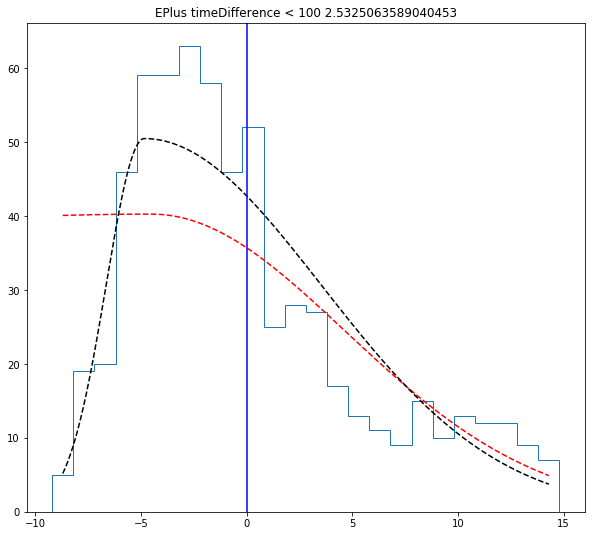

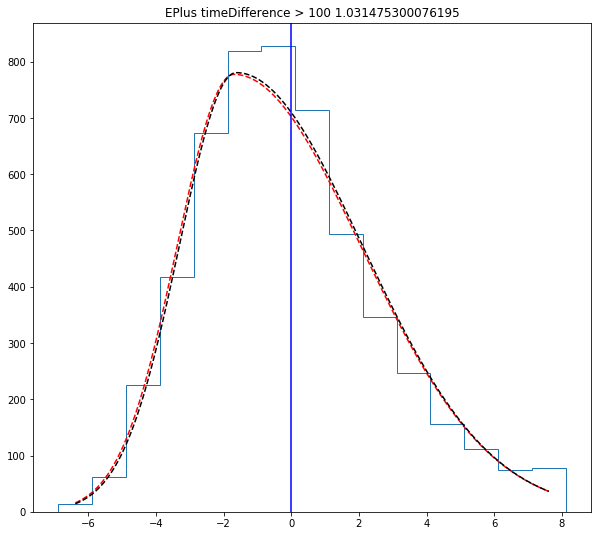

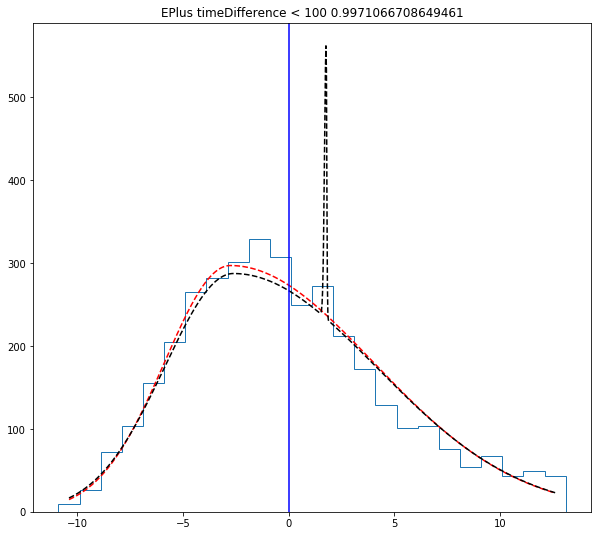

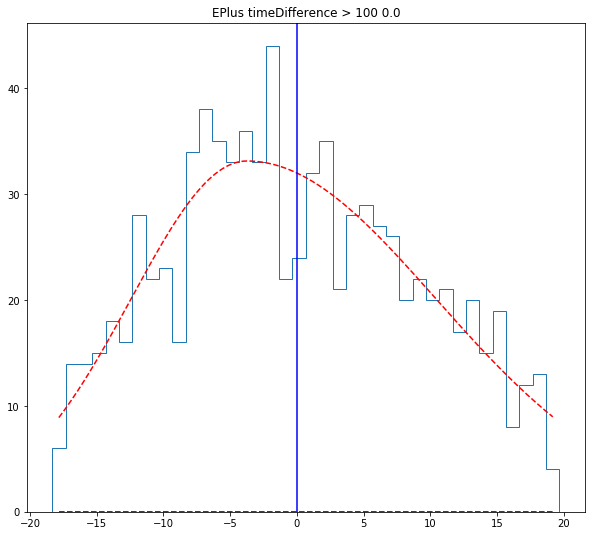

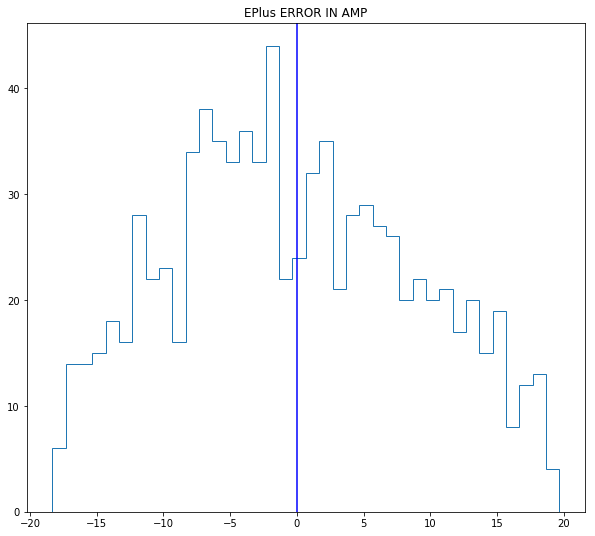

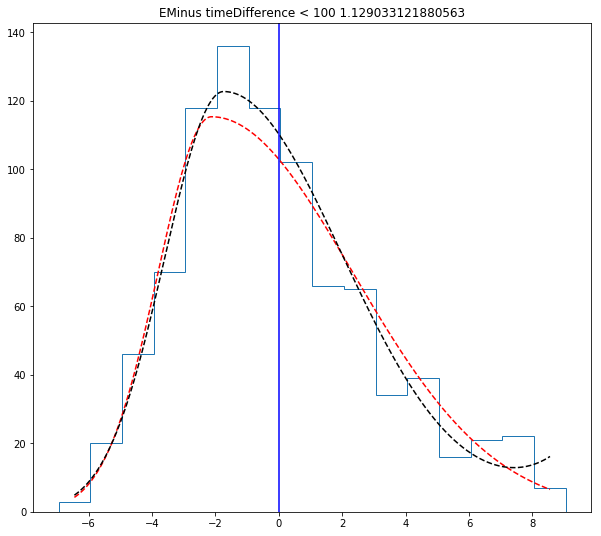

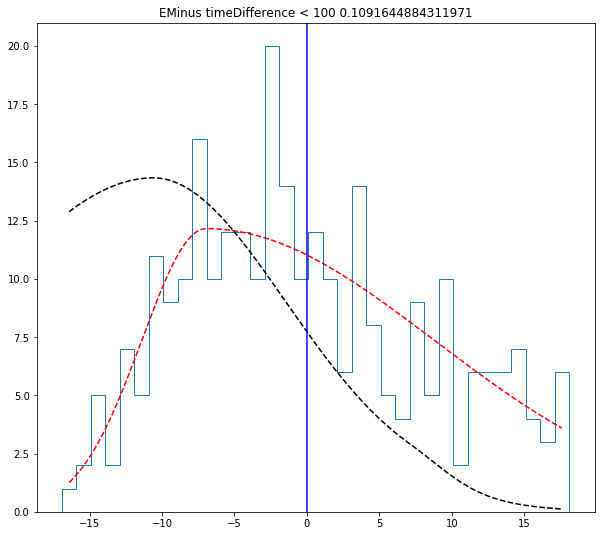

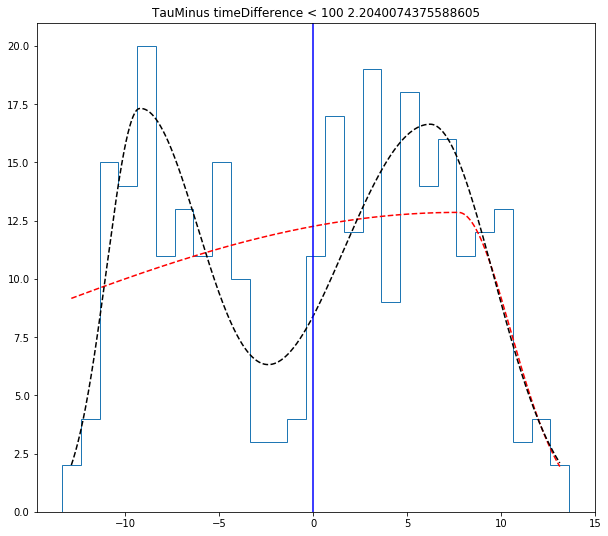

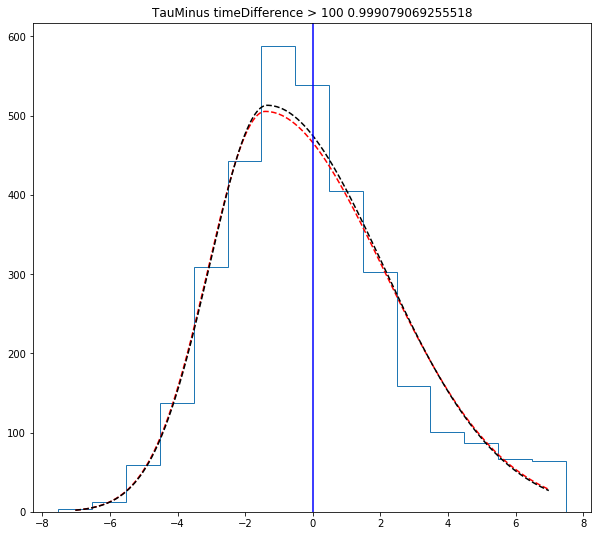

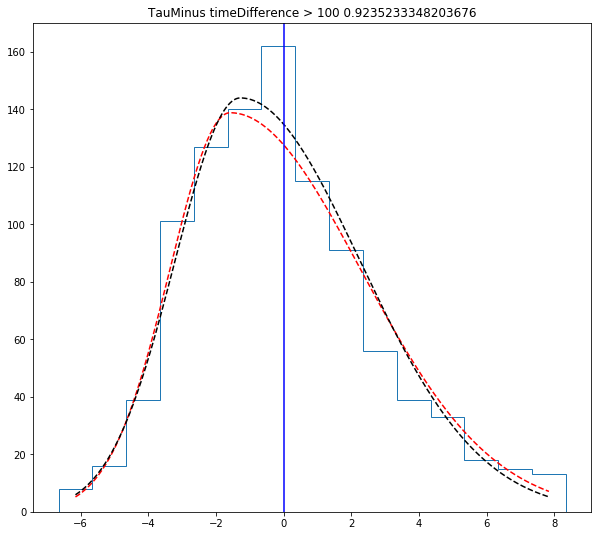

In [43]:
file = dataio.I3File(str(infile))

for frame in file:
    print('Starting')
    numHitsinDOM = ([])
    numHits = ([])
    mctree = frame["I3MCTree"]
    primary = mctree.primaries
    lepton = dataclasses.I3MCTree.first_child(mctree, primary[0].id)

    mcpeMap = frame['MCPESeriesMap']
    noiseMap = frame['NoiseSeriesMap']

    #looping through doms that have physics hits
    for omkey in mcpeMap.keys():
        oKey = omgeo.get(omkey)

        '''
        Obtaining the timeList
        '''
        noise_mcpeList = noiseMap[omkey]
        noise_timeList = np.array([mcpe.time for mcpe in noise_mcpeList])
        mcpeList = mcpeMap[omkey]
        timeList = np.array([mcpe.time for mcpe in mcpeList])
        tot_timeList = np.append(timeList, noise_timeList)
        numHitsinDOM = np.append(tot_timeList, noise_timeList)

        #print(numHitsinDOM)

    numHits = np.append(numHits, sum(numHitsinDOM))
    log_numHits = np.log10(numHits[numHits > 0])
    print(log_numHits)
    if log_numHits > 5.5 and log_numHits <= 6.0:
        likelihoodfit()


In [6]:
tot = ([])
for i in range(0, 2000):
    file = dataio.I3File('/data/p-one/akatil/step_4_medium_water/NuTau_NuE_20Events/step_4_'+str(i)+'_medium_water_custom_mDOM_noise.i3.gz')
    
    for frame in file:
        print('Starting')
        numHitsinDOM = ([])
        numHits = ([])
        mctree = frame["I3MCTree"]
        primary = mctree.primaries
        lepton = dataclasses.I3MCTree.first_child(mctree, primary[0].id)

        mcpeMap = frame['MCPESeriesMap']
        noiseMap = frame['NoiseSeriesMap']

        #looping through doms that have physics hits
        for omkey in mcpeMap.keys():
            oKey = omgeo.get(omkey)

            '''
            Obtaining the timeList
            '''
            noise_mcpeList = noiseMap[omkey]
            noise_timeList = np.array([mcpe.time for mcpe in noise_mcpeList])
            mcpeList = mcpeMap[omkey]
            timeList = np.array([mcpe.time for mcpe in mcpeList])
            tot_timeList = np.append(timeList, noise_timeList)
            numHitsinDOM = np.append(tot_timeList, noise_timeList)

            #print(numHitsinDOM)

        numHits = np.append(numHits, sum(numHitsinDOM))
        log_numHits = np.log10(numHits[numHits > 0])
        tot = np.append(tot, log_numHits)
        print(log_numHits)

Starting
[5.33727169]
Starting
[5.5625788]
Starting
[4.88557688]
Starting
[4.9967984]
Starting
[8.66875003]
Starting
[5.68705231]
Starting
[5.40682639]
Starting
[8.79263322]
Starting
[5.14676398]
Starting
[8.85459341]
Starting
[5.45707489]
Starting
[5.5450921]
Starting
[8.30604514]
Starting
[4.88026072]
Starting
[5.26333005]
Starting
[5.26288539]
Starting
[5.02375786]
Starting
[8.32451256]
Starting
[6.39512534]
Starting
[7.92016177]
Starting
[4.17715353]
Starting
[5.20154682]
Starting
[5.05308756]
Starting
[5.02010919]
Starting
[5.49466588]
Starting
[4.67057161]
Starting
[8.1514889]
Starting
[7.95092167]
Starting
[7.5522464]
Starting
[6.74650305]
Starting
[8.46184613]
Starting
[4.37621352]
Starting
[8.13258792]
Starting
[5.90510605]
Starting
[9.04072742]
Starting
[6.12718781]
Starting
[5.88048809]
Starting
[8.61699692]
Starting
[6.97733689]
Starting
[8.82979012]
Starting
[5.62241357]
Starting
[5.89563644]
Starting
[9.09217312]
Starting
[8.51159385]
Starting
[5.81627098]
Starting
[9.193

[6.36803036]
Starting
[8.17087304]
Starting
[6.3805751]
Starting
[5.59494833]
Starting
[8.7654159]
Starting
[5.99263413]
Starting
[5.76860753]
Starting
[6.74702257]
Starting
[5.74647259]
Starting
[5.5091758]
Starting
[6.36940987]
Starting
[8.06631432]
Starting
[8.89244737]
Starting
[5.70593779]
Starting
[6.49911206]
Starting
[5.54500267]
Starting
[5.9563293]
Starting
[6.03171776]
Starting
[9.17299338]
Starting
[6.45412887]
Starting
[5.40040161]
Starting
[5.65199709]
Starting
[7.72964589]
Starting
[5.58137196]
Starting
[5.59736614]
Starting
[5.31558231]
Starting
[8.59936848]
Starting
[5.48055917]
Starting
[5.30467068]
Starting
[6.1309946]
Starting
[5.23331312]
Starting
[8.70642429]
Starting
[7.70108203]
Starting
[4.86077407]
Starting
[6.44114697]
Starting
[4.38223907]
Starting
[8.59617527]
Starting
[5.64551599]
Starting
[8.00148233]
Starting
[7.13421472]
Starting
[8.7141647]
Starting
[6.21268309]
Starting
[5.28387519]
Starting
[7.86158719]
Starting
[5.51747556]
Starting
[7.95133915]
Sta

[5.03665283]
Starting
[7.93169555]
Starting
[8.9196947]
Starting
[5.63579229]
Starting
[5.50926106]
Starting
[8.28458242]
Starting
[5.61613648]
Starting
[8.4951025]
Starting
[8.66952657]
Starting
[7.34598337]
Starting
[8.5154963]
Starting
[6.38994103]
Starting
[5.72083085]
Starting
[5.49271735]
Starting
[9.22639605]
Starting
[8.796361]
Starting
[5.6823637]
Starting
[8.58114539]
Starting
[8.28815627]
Starting
[4.87893694]
Starting
[5.18998066]
Starting
[8.25171627]
Starting
[7.89430795]
Starting
[5.67460917]
Starting
[4.95575066]
Starting
[8.40104207]
Starting
[8.42350632]
Starting
[6.02447173]
Starting
[8.92967019]
Starting
[5.47843262]
Starting
[8.38747734]
Starting
[5.26985938]
Starting
[5.02920758]
Starting
[5.71146143]
Starting
[7.35036613]
Starting
[4.66380111]
Starting
[8.32717949]
Starting
[5.22462397]
Starting
[7.97830194]
Starting
[5.18825297]
Starting
[4.21664313]
Starting
[7.96989362]
Starting
[5.00498998]
Starting
[5.16004826]
Starting
[6.36845879]
Starting
[6.13079814]
Sta

[8.08635095]
Starting
[7.84506266]
Starting
[5.56546197]
Starting
[5.80406061]
Starting
[4.75253845]
Starting
[4.73432566]
Starting
[7.15065464]
Starting
[4.23878551]
Starting
[5.15996951]
Starting
[5.09943176]
Starting
[5.50850291]
Starting
[5.66005998]
Starting
[7.78532708]
Starting
[8.20492043]
Starting
[5.02077998]
Starting
[4.54986165]
Starting
[5.57094007]
Starting
[5.59335543]
Starting
[8.60020451]
Starting
[5.10450649]
Starting
[7.52410975]
Starting
[8.64543162]
Starting
[5.36003286]
Starting
[5.15630184]
Starting
[8.9605224]
Starting
[6.65915534]
Starting
[5.41724468]
Starting
[8.97762102]
Starting
[4.8861374]
Starting
[8.6440056]
Starting
[6.65206872]
Starting
[7.85279433]
Starting
[7.8819875]
Starting
[6.97311166]
Starting
[7.78096737]
Starting
[8.33352211]
Starting
[7.85045529]
Starting
[4.95756341]
Starting
[8.57364426]
Starting
[5.18776915]
Starting
[7.92050081]
Starting
[8.19140552]
Starting
[6.00945187]
Starting
[5.43923877]
Starting
[5.49076122]
Starting
[7.93006376]
S

[5.53604446]
Starting
[8.42538895]
Starting
[9.12389829]
Starting
[8.3914477]
Starting
[4.92697486]
Starting
[8.50198791]
Starting
[9.1250191]
Starting
[5.91530689]
Starting
[5.39525504]
Starting
[5.28527208]
Starting
[7.0909048]
Starting
[5.28738884]
Starting
[5.11795316]
Starting
[5.79236023]
Starting
[7.089839]
Starting
[7.24527599]
Starting
[6.60934111]
Starting
[7.36510962]
Starting
[8.00281876]
Starting
[4.1955866]
Starting
[7.74614292]
Starting
[4.05328403]
Starting
[4.38534966]
Starting
[7.25342261]
Starting
[7.92034217]
Starting
[4.7808039]
Starting
[9.33231032]
Starting
[5.98288977]
Starting
[5.56277663]
Starting
[8.83539124]
Starting
[5.5675243]
Starting
[8.61439987]
Starting
[9.01454254]
Starting
[9.08861282]
Starting
[5.65578492]
Starting
[8.50741217]
Starting
[8.04563871]
Starting
[8.43327658]
Starting
[8.8480509]
Starting
[5.43473802]
Starting
[8.56203539]
Starting
[5.65288559]
Starting
[5.74171551]
Starting
[5.43375465]
Starting
[9.02634898]
Starting
[7.10680704]
Starti

[4.06436111]
Starting
[4.77880809]
Starting
[4.1821745]
Starting
[7.42353114]
Starting
[8.11231529]
Starting
[8.66912697]
Starting
[4.14326152]
Starting
[5.43250894]
Starting
[4.86539781]
Starting
[8.10431657]
Starting
[5.00590693]
Starting
[4.96437645]
Starting
[7.31503218]
Starting
[8.58099787]
Starting
[8.10504274]
Starting
[4.65195767]
Starting
[7.77064061]
Starting
[5.47525432]
Starting
[6.41456081]
Starting
[8.72988808]
Starting
[8.75776164]
Starting
[8.45428951]
Starting
[8.56938675]
Starting
[6.34507023]
Starting
[8.51623682]
Starting
[8.28204363]
Starting
[7.76186938]
Starting
[8.40944452]
Starting
[4.20275792]
Starting
[8.78025217]
Starting
[9.04209365]
Starting
[6.63224796]
Starting
[8.68125604]
Starting
[8.54686403]
Starting
[7.32825727]
Starting
[7.53560785]
Starting
[7.32040309]
Starting
[8.51360935]
Starting
[5.15559576]
Starting
[7.12374046]
Starting
[5.58244439]
Starting
[4.74348585]
Starting
[5.52171604]
Starting
[4.92862759]
Starting
[8.10248282]
Starting
[4.80566558

[5.67455981]
Starting
[8.08485079]
Starting
[5.680804]
Starting
[8.96498896]
Starting
[6.59795109]
Starting
[5.85369741]
Starting
[6.0112525]
Starting
[6.09318437]
Starting
[8.34503187]
Starting
[6.29591106]
Starting
[7.9987323]
Starting
[6.66833694]
Starting
[6.05751398]
Starting
[8.61808393]
Starting
[6.86800702]
Starting
[5.65997987]
Starting
[5.96760542]
Starting
[8.9258221]
Starting
[8.71964456]
Starting
[6.01481332]
Starting
[6.12302686]
Starting
[5.96792157]
Starting
[6.04963495]
Starting
[6.25969874]
Starting
[6.05009081]
Starting
[5.66945476]
Starting
[4.10993657]
Starting
[5.36523555]
Starting
[4.96441854]
Starting
[8.05398458]
Starting
[5.1350218]
Starting
[7.57967716]
Starting
[7.17441584]
Starting
[4.11888719]
Starting
[5.24916251]
Starting
[7.54788726]
Starting
[6.91188338]
Starting
[5.69870956]
Starting
[7.93772214]
Starting
[8.19568667]
Starting
[7.39816985]
Starting
[7.65739237]
Starting
[7.97821596]
Starting
[8.67017942]
Starting
[8.20765601]
Starting
[5.08895227]
Sta

[9.08763204]
Starting
[8.79927991]
Starting
[9.0115984]
Starting
[7.2604858]
Starting
[8.91453283]
Starting
[9.26555697]
Starting
[5.52567606]
Starting
[7.90289955]
Starting
[5.94881977]
Starting
[5.32467404]
Starting
[8.69926701]
Starting
[5.39432727]
Starting
[6.54360355]
Starting
[5.61679131]
Starting
[5.60605628]
Starting
[5.6337816]
Starting
[6.78084079]
Starting
[8.42337648]
Starting
[5.60280357]
Starting
[5.21835312]
Starting
[8.91393234]
Starting
[5.73968873]
Starting
[7.75639508]
Starting
[6.58363221]
Starting
[6.5650596]
Starting
[5.85884725]
Starting
[6.73818214]
Starting
[5.81339592]
Starting
[6.22627331]
Starting
[5.61437279]
Starting
[9.26458142]
Starting
[5.81028789]
Starting
[6.48303769]
Starting
[6.43761024]
Starting
[8.98119228]
Starting
[5.65086292]
Starting
[5.47894856]
Starting
[8.84326822]
Starting
[8.25805227]
Starting
[6.98926853]
Starting
[5.04700448]
Starting
[6.38039455]
Starting
[8.80376134]
Starting
[8.74766421]
Starting
[6.08605592]
Starting
[8.70990882]
S

[5.72574244]
Starting
[8.98872706]
Starting
[6.25381136]
Starting
[6.05629323]
Starting
[9.17810584]
Starting
[7.49864587]
Starting
[9.01123]
Starting
[6.38311141]
Starting
[9.20688608]
Starting
[5.85405195]
Starting
[6.01587711]
Starting
[4.99956001]
Starting
[5.12508894]
Starting
[7.85777564]
Starting
[5.28571321]
Starting
[7.52156979]
Starting
[7.99237549]
Starting
[5.27098626]
Starting
[7.28637691]
Starting
[4.93200904]
Starting
[5.09844452]
Starting
[5.24778919]
Starting
[5.07995027]
Starting
[8.58912664]
Starting
[5.58000495]
Starting
[8.17859044]
Starting
[7.88732074]
Starting
[7.6447626]
Starting
[8.39566565]
Starting
[5.24796187]
Starting
[8.6068499]
Starting
[5.62781309]
Starting
[5.17494455]
Starting
[5.45397388]
Starting
[7.92465066]
Starting
[8.69127594]
Starting
[5.44613431]
Starting
[5.0295139]
Starting
[8.36027428]
Starting
[8.09355065]
Starting
[8.00177964]
Starting
[4.99162624]
Starting
[7.19713483]
Starting
[6.37193182]
Starting
[4.58999801]
Starting
[8.16706021]
Sta

[5.35485178]
Starting
[8.60535061]
Starting
[7.90704344]
Starting
[5.57161877]
Starting
[8.2237234]
Starting
[8.33872209]
Starting
[6.30700855]
Starting
[7.58702253]
Starting
[7.94574092]
Starting
[5.90147592]
Starting
[9.05760474]
Starting
[9.42922062]
Starting
[5.93811132]
Starting
[5.8070103]
Starting
[5.25138875]
Starting
[5.88085567]
Starting
[8.76331913]
Starting
[5.17220738]
Starting
[8.43419335]
Starting
[8.08668968]
Starting
[8.79052035]
Starting
[5.55202029]
Starting
[5.49558599]
Starting
[7.55815601]
Starting
[8.15373585]
Starting
[8.36169481]
Starting
[8.72157149]
Starting
[8.806308]
Starting
[4.66514629]
Starting
[4.59862742]
Starting
[8.52048285]
Starting
[8.05474094]
Starting
[5.64222644]
Starting
[9.29557741]
Starting
[5.55440117]
Starting
[5.82502467]
Starting
[5.62414923]
Starting
[5.21138943]
Starting
[5.88787775]
Starting
[8.74243161]
Starting
[8.9966616]
Starting
[8.75783236]
Starting
[6.23864904]
Starting
[8.93737461]
Starting
[5.64040296]
Starting
[8.48548788]
St

[4.20404475]
Starting
[4.6239128]
Starting
[7.3169112]
Starting
[4.06618985]
Starting
[4.55189322]
Starting
[7.24416935]
Starting
[8.47056193]
Starting
[5.12068502]
Starting
[6.51637982]
Starting
[7.53384953]
Starting
[7.34240861]
Starting
[4.19195027]
Starting
[6.46733773]
Starting
[5.47065426]
Starting
[6.55452295]
Starting
[7.22764191]
Starting
[5.26713287]
Starting
[6.16272587]
Starting
[8.31105621]
Starting
[9.09772851]
Starting
[5.81115505]
Starting
[8.79744868]
Starting
[9.14092606]
Starting
[8.63784552]
Starting
[9.16498342]
Starting
[6.66530284]
Starting
[9.0541346]
Starting
[5.73969626]
Starting
[5.88795375]
Starting
[5.64576231]
Starting
[7.90180539]
Starting
[9.20050145]
Starting
[5.78299887]
Starting
[5.86476929]
Starting
[5.33130261]
Starting
[5.03323061]
Starting
[5.43155974]
Starting
[5.89917107]
Starting
[5.73184755]
Starting
[7.84256541]
Starting
[5.28420934]
Starting
[8.35868982]
Starting
[8.62134115]
Starting
[5.15104553]
Starting
[5.42871285]
Starting
[5.81353643]


[8.38881998]
Starting
[5.08161712]
Starting
[4.11862219]
Starting
[5.05899739]
Starting
[5.11845541]
Starting
[5.71825494]
Starting
[4.56540392]
Starting
[4.43294835]
Starting
[7.64834685]
Starting
[6.68722435]
Starting
[7.58005328]
Starting
[7.1397111]
Starting
[7.5943348]
Starting
[7.11233933]
Starting
[4.5674621]
Starting
[8.01090572]
Starting
[5.06388562]
Starting
[7.70773967]
Starting
[5.08422127]
Starting
[7.10136607]
Starting
[4.89912089]
Starting
[7.22882029]
Starting
[8.72542181]
Starting
[5.03298563]
Starting
[5.24915326]
Starting
[5.21522093]
Starting
[8.65821357]
Starting
[5.9485708]
Starting
[5.83938521]
Starting
[4.47193771]
Starting
[5.20996645]
Starting
[8.32808835]
Starting
[5.6513732]
Starting
[6.2145558]
Starting
[6.75165108]
Starting
[9.16567196]
Starting
[8.04823501]
Starting
[8.57860698]
Starting
[8.16375013]
Starting
[9.03828078]
Starting
[5.41220536]
Starting
[8.41983712]
Starting
[8.86922841]
Starting
[5.41559011]
Starting
[8.49746539]
Starting
[8.76925172]
Sta

[4.71079588]
Starting
[4.74027289]
Starting
[7.3671773]
Starting
[8.51324616]
Starting
[4.20283262]
Starting
[7.6091086]
Starting
[7.61684841]
Starting
[5.21459191]
Starting
[5.86227157]
Starting
[7.47764544]
Starting
[4.63822041]
Starting
[7.95340017]
Starting
[5.89848069]
Starting
[4.18057261]
Starting
[5.23174443]
Starting
[5.82284134]
Starting
[5.63723774]
Starting
[5.27114548]
Starting
[7.53092304]
Starting
[6.97073471]
Starting
[5.34047314]
Starting
[7.36685345]
Starting
[5.09787355]
Starting
[8.69189596]
Starting
[5.49214773]
Starting
[7.21153669]
Starting
[8.57372731]
Starting
[5.60493574]
Starting
[5.09771698]
Starting
[5.66548819]
Starting
[7.80630297]
Starting
[8.30884164]
Starting
[8.23216474]
Starting
[5.49297638]
Starting
[8.99873401]
Starting
[5.51459121]
Starting
[8.97069012]
Starting
[8.8530715]
Starting
[8.41945581]
Starting
[5.48570674]
Starting
[8.43149678]
Starting
[5.28636836]
Starting
[6.71481578]
Starting
[9.06984116]
Starting
[5.5796866]
Starting
[8.85072172]
S

[8.94470503]
Starting
[8.4183446]
Starting
[5.25494319]
Starting
[5.42659058]
Starting
[8.85224101]
Starting
[8.23960459]
Starting
[7.14874539]
Starting
[5.59745251]
Starting
[8.10423678]
Starting
[6.9309821]
Starting
[5.45718164]
Starting
[8.60027575]
Starting
[8.41593041]
Starting
[6.54082711]
Starting
[8.5431776]
Starting
[7.76744098]
Starting
[8.19148507]
Starting
[7.93552147]
Starting
[5.1079789]
Starting
[6.75732334]
Starting
[8.16866928]
Starting
[4.83704914]
Starting
[4.23268077]
Starting
[5.1726811]
Starting
[6.91438853]
Starting
[4.66663944]
Starting
[5.17141694]
Starting
[8.06981189]
Starting
[7.6287464]
Starting
[7.31956712]
Starting
[7.95753752]
Starting
[8.46090717]
Starting
[7.72173878]
Starting
[7.78395948]
Starting
[7.74485524]
Starting
[8.9404367]
Starting
[8.15100728]
Starting
[8.45819089]
Starting
[5.33126969]
Starting
[8.58305502]
Starting
[8.16208066]
Starting
[8.07432242]
Starting
[7.90713614]
Starting
[7.43200179]
Starting
[5.5332351]
Starting
[5.869152]
Startin

[8.53888454]
Starting
[4.93945116]
Starting
[4.69166511]
Starting
[8.77273147]
Starting
[8.47242918]
Starting
[4.46726364]
Starting
[8.61327575]
Starting
[5.51022032]
Starting
[8.57612191]
Starting
[6.07726471]
Starting
[8.09498988]
Starting
[5.67701478]
Starting
[7.74171932]
Starting
[7.91754209]
Starting
[7.88401523]
Starting
[7.36624915]
Starting
[4.05719408]
Starting
[7.28194626]
Starting
[4.4697024]
Starting
[6.29522348]
Starting
[4.67584743]
Starting
[5.86095716]
Starting
[5.50630971]
Starting
[8.00577389]
Starting
[7.52634532]
Starting
[8.04344811]
Starting
[5.3158252]
Starting
[5.63794116]
Starting
[4.93466091]
Starting
[4.77901756]
Starting
[4.51005995]
Starting
[4.19427682]
Starting
[4.06489729]
Starting
[5.00385561]
Starting
[6.14953294]
Starting
[5.3176419]
Starting
[5.33812046]
Starting
[8.67800282]
Starting
[6.45350055]
Starting
[6.27385604]
Starting
[5.57259372]
Starting
[5.55574211]
Starting
[5.51375912]
Starting
[9.08392109]
Starting
[8.9032501]
Starting
[5.51858443]
S

[7.47319243]
Starting
[7.92275277]
Starting
[8.24770003]
Starting
[5.21814681]
Starting
[5.24610343]
Starting
[7.95348064]
Starting
[4.03800009]
Starting
[5.16456147]
Starting
[4.7927201]
Starting
[8.87529154]
Starting
[8.40660501]
Starting
[5.08418355]
Starting
[5.39329613]
Starting
[5.30998665]
Starting
[8.79230338]
Starting
[5.39974179]
Starting
[8.42583903]
Starting
[6.76972807]
Starting
[7.94892981]
Starting
[6.11061001]
Starting
[8.18707809]
Starting
[5.41034517]
Starting
[5.37251532]
Starting
[5.40547677]
Starting
[5.68634029]
Starting
[8.03538449]
Starting
[8.42908393]
Starting
[5.06859544]
Starting
[5.09615545]
Starting
[8.61190287]
Starting
[5.76947371]
Starting
[5.25321678]
Starting
[8.10137837]
Starting
[7.15750061]
Starting
[4.60570539]
Starting
[5.95602595]
Starting
[5.23921708]
Starting
[7.27844152]
Starting
[5.02441124]
Starting
[8.40565037]
Starting
[5.5131873]
Starting
[4.842892]
Starting
[4.92476438]
Starting
[6.13538253]
Starting
[4.41765028]
Starting
[8.09769913]
S

[8.5411434]
Starting
[5.88958027]
Starting
[5.24389954]
Starting
[5.40324227]
Starting
[5.39180047]
Starting
[8.51590174]
Starting
[7.46665115]
Starting
[4.99887949]
Starting
[7.40353147]
Starting
[8.31355762]
Starting
[9.0510953]
Starting
[8.5694549]
Starting
[5.70832078]
Starting
[6.02994847]
Starting
[6.85179178]
Starting
[8.47250729]
Starting
[8.24941386]
Starting
[8.4808211]
Starting
[5.35623713]
Starting
[5.18122031]
Starting
[8.55511056]
Starting
[8.52252464]
Starting
[8.93395048]
Starting
[6.26769276]
Starting
[5.65301322]
Starting
[5.30724777]
Starting
[6.53811528]
Starting
[5.95834025]
Starting
[6.17139489]
Starting
[8.58201444]
Starting
[8.64340815]
Starting
[9.01271877]
Starting
[5.4542468]
Starting
[9.05269974]
Starting
[8.3029793]
Starting
[7.99192588]
Starting
[8.54751178]
Starting
[8.60742235]
Starting
[6.81441305]
Starting
[5.58602121]
Starting
[5.62253236]
Starting
[8.64193542]
Starting
[5.29768626]
Starting
[5.5598424]
Starting
[5.02717944]
Starting
[5.0742146]
Start

[5.60463125]
Starting
[5.26831813]
Starting
[8.24679084]
Starting
[5.88308257]
Starting
[8.98701844]
Starting
[8.85061975]
Starting
[6.08553]
Starting
[8.69241759]
Starting
[6.30709991]
Starting
[5.75064196]
Starting
[8.82958374]
Starting
[5.67316064]
Starting
[9.13441152]
Starting
[5.35593408]
Starting
[8.42459169]
Starting
[8.54240449]
Starting
[5.30927551]
Starting
[8.49876509]
Starting
[8.27205362]
Starting
[6.19262017]
Starting
[4.95663089]
Starting
[4.70473344]
Starting
[5.14953594]
Starting
[6.13258423]
Starting
[5.93912134]
Starting
[8.81844927]
Starting
[8.36463203]
Starting
[5.71429214]
Starting
[5.20317287]
Starting
[5.29156517]
Starting
[5.43842886]
Starting
[9.06713107]
Starting
[5.86529028]
Starting
[5.61203558]
Starting
[6.14868022]
Starting
[6.23992186]
Starting
[5.89529447]
Starting
[6.1163542]
Starting
[9.18220319]
Starting
[8.86492479]
Starting
[8.42194822]
Starting
[6.39765327]
Starting
[5.56124328]
Starting
[5.01601824]
Starting
[5.32385093]
Starting
[8.44426904]
S

[5.51492348]
Starting
[9.01682624]
Starting
[5.61835386]
Starting
[8.43702949]
Starting
[5.55978134]
Starting
[8.92738043]
Starting
[5.50341222]
Starting
[5.91015644]
Starting
[7.94290349]
Starting
[6.46841381]
Starting
[5.63845787]
Starting
[6.22687778]
Starting
[5.52252737]
Starting
[8.41236475]
Starting
[7.97070459]
Starting
[5.35175857]
Starting
[6.05837846]
Starting
[5.29173094]
Starting
[8.95377423]
Starting
[8.77761579]
Starting
[8.79241327]
Starting
[8.86273743]
Starting
[5.37570681]
Starting
[8.06037216]
Starting
[8.12202351]
Starting
[4.84231568]
Starting
[5.90297259]
Starting
[7.55166992]
Starting
[5.24830292]
Starting
[6.95065385]
Starting
[8.60689328]
Starting
[4.13956719]
Starting
[8.34896279]
Starting
[5.04161838]
Starting
[6.76465401]
Starting
[7.39640911]
Starting
[4.77535015]
Starting
[7.9258128]
Starting
[7.4283445]
Starting
[5.34198578]
Starting
[9.12923107]
Starting
[8.41562]
Starting
[8.37637636]
Starting
[5.62110256]
Starting
[8.87395316]
Starting
[5.70730842]
St

[5.53321154]
Starting
[4.65796994]
Starting
[7.46227174]
Starting
[7.58780462]
Starting
[7.5748114]
Starting
[4.98736362]
Starting
[5.02547548]
Starting
[4.48094336]
Starting
[7.90926039]
Starting
[8.03720071]
Starting
[8.57620601]
Starting
[6.27768404]
Starting
[5.64037885]
Starting
[8.45117807]
Starting
[8.68531371]
Starting
[4.94785471]
Starting
[5.81898359]
Starting
[8.55965796]
Starting
[5.46123714]
Starting
[5.78143439]
Starting
[5.68826968]
Starting
[6.01846956]
Starting
[8.85642663]
Starting
[5.58799639]
Starting
[9.07660804]
Starting
[6.16509039]
Starting
[8.50885014]
Starting
[5.41344374]
Starting
[6.16274678]
Starting
[7.74567966]
Starting
[5.60634687]
Starting
[5.4341057]
Starting
[8.69846849]
Starting
[5.50802919]
Starting
[5.8193971]
Starting
[5.6045754]
Starting
[9.07758007]
Starting
[8.18354899]
Starting
[9.02931091]
Starting
[8.58160254]
Starting
[5.47765158]
Starting
[5.62041401]
Starting
[9.02244299]
Starting
[5.69957996]
Starting
[5.66308909]
Starting
[6.05574261]
S

[7.89122076]
Starting
[5.61449895]
Starting
[5.26179109]
Starting
[7.96762081]
Starting
[7.3674663]
Starting
[5.06887211]
Starting
[7.73127407]
Starting
[8.29416899]
Starting
[7.71447701]
Starting
[8.32828802]
Starting
[5.01651678]
Starting
[8.25189089]
Starting
[4.80818704]
Starting
[5.49722682]
Starting
[4.33374542]
Starting
[4.67107441]
Starting
[4.9719709]
Starting
[6.82358199]
Starting
[4.33256271]
Starting
[8.78899786]
Starting
[8.70077334]
Starting
[9.03955042]
Starting
[8.26743638]
Starting
[9.13116194]
Starting
[6.00453653]
Starting
[5.44653321]
Starting
[8.5552929]
Starting
[7.55244278]
Starting
[8.81343045]
Starting
[5.63056415]
Starting
[6.94495159]
Starting
[6.40666402]
Starting
[8.52726357]
Starting
[5.18537828]
Starting
[8.32502899]
Starting
[5.6385449]
Starting
[8.70132086]
Starting
[5.56053357]
Starting
[5.54763291]
Starting
[5.86881494]
Starting
[8.82835793]
Starting
[5.35045484]
Starting
[8.34992202]
Starting
[8.09316443]
Starting
[5.51354698]
Starting
[8.87147651]
S

[5.50442063]
Starting
[8.7021349]
Starting
[5.17093502]
Starting
[4.95664477]
Starting
[8.74845503]
Starting
[5.25540817]
Starting
[4.89523926]
Starting
[8.84061077]
Starting
[8.5935973]
Starting
[5.87868509]
Starting
[8.77450696]
Starting
[8.08590745]
Starting
[8.67954831]
Starting
[5.79695765]
Starting
[8.77417634]
Starting
[9.08580935]
Starting
[8.69770481]
Starting
[8.56362948]
Starting
[7.90228749]
Starting
[5.65209467]
Starting
[6.96596132]
Starting
[8.97530176]
Starting
[8.39964795]
Starting
[9.15004837]
Starting
[8.12073963]
Starting
[8.59080086]
Starting
[4.13152597]
Starting
[5.40100031]
Starting
[5.06327989]
Starting
[8.84709634]
Starting
[8.20210464]
Starting
[6.38565971]
Starting
[7.72296515]
Starting
[7.99242235]
Starting
[7.77803376]
Starting
[8.2035246]
Starting
[5.90811797]
Starting
[5.40158808]
Starting
[5.55108152]
Starting
[7.69720279]
Starting
[8.31679354]
Starting
[6.46555578]
Starting
[5.82152353]
Starting
[7.4067126]
Starting
[8.80621435]
Starting
[8.56234429]
S

[5.62453739]
Starting
[8.69103301]
Starting
[8.07171688]
Starting
[5.50258523]
Starting
[8.76908132]
Starting
[5.51711529]
Starting
[8.65796049]
Starting
[8.45355227]
Starting
[7.59820246]
Starting
[8.51097113]
Starting
[8.507248]
Starting
[8.20352777]
Starting
[8.18781683]
Starting
[6.60241614]
Starting
[5.87126376]
Starting
[8.06029878]
Starting
[8.03399899]
Starting
[5.58594863]
Starting
[5.09042293]
Starting
[5.7061631]
Starting
[8.59606535]
Starting
[8.01010686]
Starting
[6.43249895]
Starting
[7.90753739]
Starting
[8.26349058]
Starting
[4.99405682]
Starting
[5.55390414]
Starting
[5.87771549]
Starting
[8.49770872]
Starting
[7.95607566]
Starting
[5.49274501]
Starting
[5.54991917]
Starting
[5.6408005]
Starting
[8.0332753]
Starting
[6.59342911]
Starting
[5.49330918]
Starting
[8.87431406]
Starting
[9.04928397]
Starting
[5.58736375]
Starting
[8.26005263]
Starting
[8.79489119]
Starting
[7.85120024]
Starting
[5.51399334]
Starting
[5.39310066]
Starting
[7.12262634]
Starting
[5.46937914]
St

[5.96262989]
Starting
[8.60588377]
Starting
[5.76245907]
Starting
[5.91330003]
Starting
[5.59695916]
Starting
[5.78648276]
Starting
[8.54187626]
Starting
[5.52781828]
Starting
[5.02802706]
Starting
[7.40628729]
Starting
[7.81715795]
Starting
[8.52187211]
Starting
[8.87463371]
Starting
[5.66858455]
Starting
[5.18309594]
Starting
[5.06006777]
Starting
[5.07228634]
Starting
[5.56441228]
Starting
[7.83528024]
Starting
[7.49710419]
Starting
[6.00883171]
Starting
[4.8092009]
Starting
[7.48580547]
Starting
[5.61586939]
Starting
[4.95117081]
Starting
[5.23388358]
Starting
[8.51054]
Starting
[8.28780489]
Starting
[8.32245214]
Starting
[6.10153947]
Starting
[8.26822775]
Starting
[7.24001231]
Starting
[5.45910295]
Starting
[5.18320905]
Starting
[5.36902639]
Starting
[8.07203469]
Starting
[8.41686144]
Starting
[4.8527181]
Starting
[8.06167763]
Starting
[8.3708667]
Starting
[4.68297192]
Starting
[8.48607217]
Starting
[8.3400491]
Starting
[8.06173407]
Starting
[5.5078441]
Starting
[5.49999222]
Start

[6.15824463]
Starting
[8.88117024]
Starting
[5.67080559]
Starting
[8.33485284]
Starting
[6.59443878]
Starting
[5.28903104]
Starting
[8.95331233]
Starting
[8.2088302]
Starting
[5.38550056]
Starting
[5.58635099]
Starting
[5.55825734]
Starting
[7.96180558]
Starting
[8.65876112]
Starting
[8.64366505]
Starting
[8.33128088]
Starting
[8.83965606]
Starting
[8.63690962]
Starting
[5.68334422]
Starting
[9.03816593]
Starting
[5.7078136]
Starting
[5.40959811]
Starting
[5.63863026]
Starting
[5.49715275]
Starting
[8.61979956]
Starting
[5.41609123]
Starting
[5.63627008]
Starting
[5.57994453]
Starting
[8.63009638]
Starting
[5.31684406]
Starting
[8.68021975]
Starting
[6.1099828]
Starting
[5.63274642]
Starting
[5.77314027]
Starting
[7.96606186]
Starting
[5.43769027]
Starting
[5.51839894]
Starting
[8.77495146]
Starting
[5.07620708]
Starting
[7.60933124]
Starting
[5.9081409]
Starting
[8.63346336]
Starting
[9.01006757]
Starting
[7.93783368]
Starting
[8.56956837]
Starting
[8.98697673]
Starting
[8.84525307]
S

[7.07009964]
Starting
[5.39038573]
Starting
[7.31038426]
Starting
[4.81447288]
Starting
[8.64420545]
Starting
[5.79280599]
Starting
[6.01454758]
Starting
[7.47152452]
Starting
[4.98912881]
Starting
[6.76696633]
Starting
[4.87591141]
Starting
[8.10177546]
Starting
[8.05434027]
Starting
[6.51232082]
Starting
[4.49300918]
Starting
[5.57393996]
Starting
[4.78349416]
Starting
[5.62495117]
Starting
[8.51725909]
Starting
[9.15135708]
Starting
[5.30655613]
Starting
[7.37009]
Starting
[8.36517085]
Starting
[5.42547283]
Starting
[5.90752417]
Starting
[5.09398133]
Starting
[8.6639306]
Starting
[8.49644648]
Starting
[5.53182865]
Starting
[9.14773272]
Starting
[8.23179035]
Starting
[8.62532636]
Starting
[8.98562145]
Starting
[5.2981684]
Starting
[8.92050521]
Starting
[8.84949544]
Starting
[4.92876965]
Starting
[8.29369334]
Starting
[5.51458245]
Starting
[8.88600825]
Starting
[5.69607509]
Starting
[8.66387178]
Starting
[8.51536164]
Starting
[5.66061053]
Starting
[8.7149124]
Starting
[9.10751978]
Sta

[6.09910734]
Starting
[8.16729186]
Starting
[7.29089988]
Starting
[8.78745628]
Starting
[8.26671972]
Starting
[8.7851664]
Starting
[5.33501614]
Starting
[9.13223322]
Starting
[8.55868498]
Starting
[4.78009927]
Starting
[5.10996719]
Starting
[4.53418001]
Starting
[5.3830894]
Starting
[8.53159017]
Starting
[6.04843812]
Starting
[8.37169734]
Starting
[8.26723017]
Starting
[5.27955982]
Starting
[5.15847829]
Starting
[8.71695359]
Starting
[6.44576412]
Starting
[8.25462834]
Starting
[8.15965329]
Starting
[6.7111706]
Starting
[4.82328185]
Starting
[8.67293388]
Starting
[8.36696661]
Starting
[7.5148838]
Starting
[5.20972194]
Starting
[7.62989485]
Starting
[8.4307246]
Starting
[5.21333671]
Starting
[5.63806332]
Starting
[7.83167973]
Starting
[7.12164233]
Starting
[5.34078118]
Starting
[4.84703209]
Starting
[5.04581236]
Starting
[8.77802988]
Starting
[8.16997445]
Starting
[7.38900861]
Starting
[5.20564976]
Starting
[7.51719662]
Starting
[8.31838626]
Starting
[8.20478207]
Starting
[8.72690576]
St

[5.42625667]
Starting
[8.06508869]
Starting
[5.53911992]
Starting
[5.18556854]
Starting
[7.68172338]
Starting
[6.53315095]
Starting
[8.2146955]
Starting
[7.2374631]
Starting
[4.84861143]
Starting
[4.77235342]
Starting
[5.98050216]
Starting
[4.49545621]
Starting
[5.09273181]
Starting
[5.28890801]
Starting
[8.18407335]
Starting
[7.69471252]
Starting
[5.45859861]
Starting
[7.03995814]
Starting
[5.01071914]
Starting
[4.56284]
Starting
[7.66111467]
Starting
[7.51771754]
Starting
[8.08000813]
Starting
[8.39646483]
Starting
[5.2693811]
Starting
[8.59753024]
Starting
[7.5287175]
Starting
[8.96547189]
Starting
[7.35518116]
Starting
[5.33049943]
Starting
[6.02062008]
Starting
[8.20117885]
Starting
[7.73435158]
Starting
[5.35390549]
Starting
[5.48991212]
Starting
[6.37662039]
Starting
[5.43440113]
Starting
[5.25097278]
Starting
[4.6799748]
Starting
[7.70967794]
Starting
[6.73768803]
Starting
[7.62790193]
Starting
[8.09395987]
Starting
[7.49389412]
Starting
[7.80468277]
Starting
[8.08926834]
Start

[8.05289954]
Starting
[5.66987748]
Starting
[8.11128144]
Starting
[8.31198796]
Starting
[8.7240249]
Starting
[8.33698158]
Starting
[5.45635321]
Starting
[5.83069612]
Starting
[5.52892749]
Starting
[5.56609776]
Starting
[5.31745499]
Starting
[5.5406864]
Starting
[5.772703]
Starting
[8.29638208]
Starting
[5.36291846]
Starting
[5.02596596]
Starting
[9.0978763]
Starting
[8.92276078]
Starting
[7.24144297]
Starting
[8.73831579]
Starting
[8.1469228]
Starting
[6.84287247]
Starting
[8.72636729]
Starting
[8.17489599]
Starting
[5.41409774]
Starting
[5.67892702]
Starting
[8.33220511]
Starting
[8.92349025]
Starting
[9.107262]
Starting
[8.35774084]
Starting
[9.0066831]
Starting
[8.57362173]
Starting
[8.67414043]
Starting
[4.85045328]
Starting
[8.14456789]
Starting
[8.2414332]
Starting
[8.12776292]
Starting
[8.1371388]
Starting
[5.18515448]
Starting
[5.50980158]
Starting
[7.4101318]
Starting
[7.85672568]
Starting
[5.09414389]
Starting
[7.86823585]
Starting
[5.3002885]
Starting
[4.84910795]
Starting
[

[8.62964568]
Starting
[8.81652818]
Starting
[8.2431809]
Starting
[8.79321178]
Starting
[7.8533689]
Starting
[5.15247235]
Starting
[5.47951245]
Starting
[8.6001748]
Starting
[5.43696608]
Starting
[4.59938674]
Starting
[4.19941118]
Starting
[7.34357873]
Starting
[7.79899211]
Starting
[7.88538114]
Starting
[7.56411626]
Starting
[5.14189887]
Starting
[4.05020402]
Starting
[7.89428146]
Starting
[8.04885469]
Starting
[4.5383853]
Starting
[5.13255658]
Starting
[4.26418172]
Starting
[5.09580763]
Starting
[4.69658216]
Starting
[7.26062118]
Starting
[4.54952029]
Starting
[8.21387546]
Starting
[7.6646334]
Starting
[8.25168827]
Starting
[7.94233108]
Starting
[4.99937315]
Starting
[4.26906751]
Starting
[4.65448409]
Starting
[7.80056303]
Starting
[7.22238017]
Starting
[5.34551203]
Starting
[5.03078404]
Starting
[4.91916333]
Starting
[6.83470996]
Starting
[8.22203285]
Starting
[5.70145465]
Starting
[8.62849376]
Starting
[5.94591732]
Starting
[6.19236678]
Starting
[8.48790993]
Starting
[7.41233249]
St

[8.04756496]
Starting
[8.58795378]
Starting
[7.15366612]
Starting
[4.91772749]
Starting
[4.83126449]
Starting
[4.76288344]
Starting
[8.25613504]
Starting
[5.27653662]
Starting
[5.07001343]
Starting
[7.89980895]
Starting
[8.60832243]
Starting
[8.495739]
Starting
[4.15764087]
Starting
[8.23026047]
Starting
[7.41718558]
Starting
[4.89833638]
Starting
[5.63136332]
Starting
[4.06050117]
Starting
[7.9267208]
Starting
[4.64669241]
Starting
[7.86994171]
Starting
[5.78534781]
Starting
[4.86861816]
Starting
[4.97883694]
Starting
[7.34811699]
Starting
[6.74382411]
Starting
[8.15617541]
Starting
[7.35879111]
Starting
[8.52746007]
Starting
[8.57347149]
Starting
[8.56776799]
Starting
[7.95135425]
Starting
[7.6643873]
Starting
[5.28938622]
Starting
[6.18012514]
Starting
[7.26810893]
Starting
[4.91223074]
Starting
[5.22868763]
Starting
[5.21761025]
Starting
[5.42870779]
Starting
[8.62538382]
Starting
[8.68998919]
Starting
[8.41100782]
Starting
[4.90133734]
Starting
[8.90846663]
Starting
[8.59827184]
S

Starting
[5.11900285]
Starting
[5.85124878]
Starting
[6.3859789]
Starting
[5.34956508]
Starting
[5.85741356]
Starting
[4.05881401]
Starting
[5.09664009]
Starting
[4.91077034]
Starting
[4.74300454]
Starting
[4.05847833]
Starting
[5.15151372]
Starting
[5.86646171]
Starting
[4.76229553]
Starting
[4.4491886]
Starting
[5.24682979]
Starting
[5.9552616]
Starting
[4.70707445]
Starting
[8.46231987]
Starting
[4.96645797]
Starting
[7.43516381]
Starting
[4.00702128]
Starting
[8.93539898]
Starting
[6.09012498]
Starting
[5.58859217]
Starting
[5.61818406]
Starting
[6.17432655]
Starting
[9.03421748]
Starting
[5.41675284]
Starting
[5.60118211]
Starting
[5.7559169]
Starting
[8.32127806]
Starting
[5.83019025]
Starting
[6.01255035]
Starting
[6.32809383]
Starting
[5.78647298]
Starting
[5.63210706]
Starting
[9.49796973]
Starting
[6.04666946]
Starting
[9.10879481]
Starting
[8.87475304]
Starting
[5.63610918]
Starting
[9.22732599]
Starting
[8.69644909]
Starting
[8.7900321]
Starting
[6.45729318]
Starting
[8.904

[8.33878857]
Starting
[7.95648716]
Starting
[5.30602215]
Starting
[5.71200427]
Starting
[8.35213459]
Starting
[4.74130959]
Starting
[8.72387906]
Starting
[5.43676771]
Starting
[5.3687927]
Starting
[6.67102382]
Starting
[7.94410792]
Starting
[8.75889397]
Starting
[8.81865028]
Starting
[8.11763461]
Starting
[5.58071204]
Starting
[5.03339431]
Starting
[7.92449029]
Starting
[8.46201789]
Starting
[5.00523227]
Starting
[5.46517803]
Starting
[8.15352737]
Starting
[6.95171242]
Starting
[5.80299628]
Starting
[7.92182274]
Starting
[5.03474835]
Starting
[5.7332285]
Starting
[7.16617894]
Starting
[5.3337879]
Starting
[4.87992604]
Starting
[8.66908382]
Starting
[5.51232153]
Starting
[8.68674588]
Starting
[5.06269634]
Starting
[8.26546908]
Starting
[5.10475971]
Starting
[7.42949951]
Starting
[5.73704752]
Starting
[8.2808415]
Starting
[5.92419345]
Starting
[5.30011103]
Starting
[8.35528637]
Starting
[7.91588443]
Starting
[5.05645318]
Starting
[5.37845453]
Starting
[7.67766285]
Starting
[8.08381436]
S

[8.01192986]
Starting
[5.6003011]
Starting
[5.19972193]
Starting
[5.37161081]
Starting
[8.82407956]
Starting
[5.72819472]
Starting
[8.76486651]
Starting
[5.27556625]
Starting
[8.57360073]
Starting
[5.7464348]
Starting
[6.00580266]
Starting
[8.55358891]
Starting
[5.32144662]
Starting
[5.34387805]
Starting
[8.19290421]
Starting
[5.20019321]
Starting
[8.07398067]
Starting
[8.16842502]
Starting
[8.32651616]
Starting
[8.62409223]
Starting
[7.89626652]
Starting
[8.49022584]
Starting
[8.56607249]
Starting
[5.12446269]
Starting
[5.49477784]
Starting
[8.24498238]
Starting
[7.908893]
Starting
[8.63976927]
Starting
[8.99235287]
Starting
[5.52923199]
Starting
[7.23419061]
Starting
[5.71514517]
Starting
[8.81108401]
Starting
[5.04631531]
Starting
[8.54970616]
Starting
[7.09151052]
Starting
[6.47910633]
Starting
[5.95779324]
Starting
[6.95137971]
Starting
[8.51697403]
Starting
[5.7558625]
Starting
[8.87476034]
Starting
[5.66090454]
Starting
[6.43237559]
Starting
[5.70289351]
Starting
[5.52463883]
St

[8.91490379]
Starting
[8.61953435]
Starting
[8.88621356]
Starting
[5.18044066]
Starting
[8.74114416]
Starting
[5.8999702]
Starting
[9.07999764]
Starting
[5.60785665]
Starting
[8.71773834]
Starting
[5.70366052]
Starting
[5.62528131]
Starting
[8.67198197]
Starting
[5.52846991]
Starting
[5.13796413]
Starting
[5.3631118]
Starting
[4.89101532]
Starting
[4.10769958]
Starting
[3.99935512]
Starting
[6.47424064]
Starting
[5.91867944]
Starting
[5.65022548]
Starting
[4.75141266]
Starting
[5.86785186]
Starting
[8.12868198]
Starting
[8.26615871]
Starting
[8.00442637]
Starting
[8.17431099]
Starting
[6.38519945]
Starting
[8.43456126]
Starting
[7.98351536]
Starting
[8.94636391]
Starting
[6.10193387]
Starting
[5.92979986]
Starting
[5.28803462]
Starting
[8.54897736]
Starting
[8.61805328]
Starting
[7.36821835]
Starting
[8.52624212]
Starting
[5.18384133]
Starting
[8.62601193]
Starting
[5.55464252]
Starting
[5.69211012]
Starting
[8.90028033]
Starting
[5.75891424]
Starting
[5.28165835]
Starting
[4.81747796]

[4.76088279]
Starting
[4.93280675]
Starting
[8.36855641]
Starting
[5.87461922]
Starting
[5.7398574]
Starting
[7.36278511]
Starting
[6.00691932]
Starting
[9.06233565]
Starting
[8.71104292]
Starting
[9.05124445]
Starting
[8.42835468]
Starting
[9.29870147]
Starting
[8.91410776]
Starting
[7.81855779]
Starting
[8.46943071]
Starting
[8.47847144]
Starting
[5.7361889]
Starting
[5.73092647]
Starting
[5.80894701]
Starting
[8.09176301]
Starting
[8.33923868]
Starting
[8.72793056]
Starting
[5.55972449]
Starting
[8.65147414]
Starting
[5.6524757]
Starting
[5.18270015]
Starting
[8.33839092]
Starting
[8.0696047]
Starting
[7.34259119]
Starting
[6.23182997]
Starting
[5.82887094]
Starting
[6.02873649]
Starting
[8.55359452]
Starting
[6.66459783]
Starting
[5.33474681]
Starting
[4.14303274]
Starting
[5.21823462]
Starting
[5.75536193]
Starting
[8.30249986]
Starting
[7.61284812]
Starting
[4.81802147]
Starting
[8.03859305]
Starting
[7.40513915]
Starting
[8.29127994]
Starting
[6.92960319]
Starting
[9.66309558]
S

[8.76250083]
Starting
[7.53770418]
Starting
[7.85589694]
Starting
[5.16840581]
Starting
[7.63525705]
Starting
[5.45554352]
Starting
[8.48016136]
Starting
[7.60602496]
Starting
[5.91991112]
Starting
[7.01472896]
Starting
[8.65428718]
Starting
[7.38041056]
Starting
[7.94013656]
Starting
[4.46986303]
Starting
[8.36356985]
Starting
[8.01876401]
Starting
[8.18991764]
Starting
[8.06744296]
Starting
[4.88886736]
Starting
[8.15995205]
Starting
[7.51829676]
Starting
[7.77665825]
Starting
[7.99410764]
Starting
[4.13853844]
Starting
[5.24979776]
Starting
[4.17894168]
Starting
[5.28209807]
Starting
[4.62203612]
Starting
[4.8217506]
Starting
[4.48573665]
Starting
[8.0608666]
Starting
[4.13687581]
Starting
[5.50263142]
Starting
[4.27154249]
Starting
[7.45268864]
Starting
[5.13841189]
Starting
[7.85100439]
Starting
[7.2200597]
Starting
[4.40727242]
Starting
[7.60946726]
Starting
[8.05827077]
Starting
[5.48708346]
Starting
[7.11073597]
Starting
[7.4615056]
Starting
[7.47126939]
Starting
[7.88603981]
S

[5.69372684]
Starting
[5.48761973]
Starting
[8.97615964]
Starting
[9.1672418]
Starting
[8.64373593]
Starting
[6.01515912]
Starting
[8.59698358]
Starting
[9.21749054]
Starting
[8.73736181]
Starting
[5.58950904]
Starting
[6.52279161]
Starting
[8.66748256]
Starting
[8.50796911]
Starting
[8.77069499]
Starting
[9.02742201]
Starting
[6.18606448]
Starting
[9.00208553]
Starting
[6.50372109]
Starting
[9.0099192]
Starting
[5.67429547]
Starting
[5.74706584]
Starting
[6.80490247]
Starting
[9.18215421]
Starting
[5.35697008]
Starting
[5.84422027]
Starting
[5.52005205]
Starting
[6.28017591]
Starting
[8.47365055]
Starting
[5.92525326]
Starting
[9.0637591]
Starting
[8.98453108]
Starting
[9.13518161]
Starting
[6.49547929]
Starting
[6.19118685]
Starting
[5.2563965]
Starting
[8.75262286]
Starting
[8.8813967]
Starting
[8.64614445]
Starting
[8.46990888]
Starting
[5.4093535]
Starting
[5.45718851]
Starting
[5.79186384]
Starting
[5.42579301]
Starting
[6.25698528]
Starting
[5.66220507]
Starting
[8.33733494]
Sta

[8.66036093]
Starting
[6.34582167]
Starting
[5.60241147]
Starting
[5.50121951]
Starting
[8.67806151]
Starting
[5.7224971]
Starting
[5.5442312]
Starting
[5.79580071]
Starting
[8.88320312]
Starting
[5.53830858]
Starting
[8.84782445]
Starting
[5.49788883]
Starting
[8.6889261]
Starting
[5.54495615]
Starting
[8.11272491]
Starting
[5.48143985]
Starting
[7.86420394]
Starting
[5.87112032]
Starting
[8.27917117]
Starting
[7.84915522]
Starting
[8.81844109]
Starting
[5.58704525]
Starting
[6.30179848]
Starting
[7.47399361]
Starting
[6.16427136]
Starting
[5.64970873]
Starting
[6.12779872]
Starting
[7.94544268]
Starting
[8.22473704]
Starting
[8.05403209]
Starting
[4.88566497]
Starting
[4.94559138]
Starting
[8.00433821]
Starting
[8.22884134]
Starting
[4.70696482]
Starting
[7.86404531]
Starting
[5.2222431]
Starting
[9.54809488]
Starting
[6.8243723]
Starting
[5.72406795]
Starting
[4.75814689]
Starting
[8.27970824]
Starting
[7.99062008]
Starting
[5.36658267]
Starting
[7.2971743]
Starting
[5.67948166]
Sta

[8.6062137]
Starting
[6.15544733]
Starting
[6.14736977]
Starting
[8.91398229]
Starting
[5.40473933]
Starting
[5.8742406]
Starting
[5.65626393]
Starting
[8.93014899]
Starting
[6.94424115]
Starting
[4.15181246]
Starting
[4.25267194]
Starting
[5.33179629]
Starting
[7.44350556]
Starting
[4.8155485]
Starting
[7.31333915]
Starting
[4.1550149]
Starting
[5.43224244]
Starting
[4.52789524]
Starting
[7.68414902]
Starting
[5.03173672]
Starting
[4.73516222]
Starting
[7.72170903]
Starting
[4.15789779]
Starting
[6.84121188]
Starting
[7.85007168]
Starting
[5.60122991]
Starting
[8.04134323]
Starting
[7.87584814]
Starting
[8.57399542]
Starting
[8.96434526]
Starting
[9.09041289]
Starting
[7.05240974]
Starting
[5.6494843]
Starting
[8.23693081]
Starting
[9.01888908]
Starting
[8.62800789]
Starting
[6.56155384]
Starting
[8.33779568]
Starting
[6.4099973]
Starting
[6.94781361]
Starting
[8.20775159]
Starting
[8.67758164]
Starting
[5.42632286]
Starting
[8.83308287]
Starting
[7.26960177]
Starting
[5.21581612]
Sta

[8.11676313]
Starting
[5.10326761]
Starting
[5.35387313]
Starting
[5.06968257]
Starting
[7.55896441]
Starting
[6.03964537]
Starting
[8.65312205]
Starting
[7.6355997]
Starting
[5.80722023]
Starting
[5.84657526]
Starting
[8.53355394]
Starting
[9.27181732]
Starting
[5.85146911]
Starting
[5.60384087]
Starting
[7.49705101]
Starting
[5.45336194]
Starting
[5.97195261]
Starting
[9.11161443]
Starting
[5.32434162]
Starting
[5.75017903]
Starting
[5.79754769]
Starting
[8.64474489]
Starting
[6.37693546]
Starting
[8.42801359]
Starting
[5.65460032]
Starting
[5.24708316]
Starting
[6.92576749]
Starting
[5.61808954]
Starting
[6.13394593]
Starting
[8.42559332]
Starting
[5.77549691]
Starting
[8.846017]
Starting
[8.61447747]
Starting
[6.35344432]
Starting
[5.48463735]
Starting
[5.02048205]
Starting
[7.93623843]
Starting
[9.12214592]
Starting
[5.13736243]
Starting
[6.04845979]
Starting
[5.6791911]
Starting
[8.44677423]
Starting
[5.12747157]
Starting
[7.11855011]
Starting
[8.94478064]
Starting
[5.2462587]
St

[8.85581014]
Starting
[7.12607095]
Starting
[8.16991275]
Starting
[7.91978872]
Starting
[4.98919941]
Starting
[7.11659842]
Starting
[8.0296233]
Starting
[4.42845914]
Starting
[5.86337292]
Starting
[9.03074936]
Starting
[8.44452954]
Starting
[5.67277622]
Starting
[8.83046161]
Starting
[5.53286923]
Starting
[5.50877365]
Starting
[9.22940427]
Starting
[6.11759208]
Starting
[5.76911274]
Starting
[5.87886109]
Starting
[5.77410663]
Starting
[5.46647023]
Starting
[5.4661548]
Starting
[5.95262204]
Starting
[5.59592906]
Starting
[8.80175768]
Starting
[9.05845265]
Starting
[8.23050138]
Starting
[8.31253546]
Starting
[5.36656322]
Starting
[5.34181857]
Starting
[5.71665427]
Starting
[8.3867423]
Starting
[5.34420262]
Starting
[9.09657261]
Starting
[5.27331824]
Starting
[5.19387853]
Starting
[5.33185543]
Starting
[5.25672091]
Starting
[7.2573043]
Starting
[5.39255408]
Starting
[8.29792135]
Starting
[8.7173517]
Starting
[5.647624]
Starting
[4.93316929]
Starting
[4.80314791]
Starting
[8.84404554]
Star

[5.65244157]
Starting
[8.35629925]
Starting
[8.59509893]
Starting
[6.19041473]
Starting
[5.52681631]
Starting
[9.15725959]
Starting
[8.97843183]
Starting
[9.14232805]
Starting
[8.9436369]
Starting
[9.19028067]
Starting
[9.78716113]
Starting
[7.47910007]
Starting
[9.24087483]
Starting
[8.15617836]
Starting
[9.26556428]
Starting
[6.10683062]
Starting
[5.12124608]
Starting
[5.33646274]
Starting
[8.68770387]
Starting
[8.80790854]
Starting
[8.46121169]
Starting
[8.53370135]
Starting
[8.73645507]
Starting
[8.65175157]
Starting
[4.71583599]
Starting
[8.49098048]
Starting
[5.12071547]
Starting
[5.64871382]
Starting
[5.52858684]
Starting
[6.1993688]
Starting
[5.88171141]
Starting
[8.85323314]
Starting
[5.73991592]
Starting
[5.64392875]
Starting
[8.74395617]
Starting
[8.82219151]
Starting
[5.48348664]
Starting
[8.66650664]
Starting
[5.43468576]
Starting
[8.39335701]
Starting
[6.02928573]
Starting
[8.94546002]
Starting
[9.02117626]
Starting
[6.46796611]
Starting
[8.93894712]
Starting
[5.17924726]

[8.21981933]
Starting
[8.65438827]
Starting
[5.73797469]
Starting
[8.44217752]
Starting
[8.28523339]
Starting
[8.19022198]
Starting
[8.13081264]
Starting
[8.89260433]
Starting
[7.54366883]
Starting
[5.89610518]
Starting
[8.48972286]
Starting
[8.92699575]
Starting
[8.78606204]
Starting
[5.32452823]
Starting
[5.57582206]
Starting
[8.29747126]
Starting
[8.72060189]
Starting
[5.63030903]
Starting
[8.63920333]
Starting
[5.13879151]
Starting
[6.4158001]
Starting
[5.53340602]
Starting
[5.65227951]
Starting
[8.54915237]
Starting
[5.58235986]
Starting
[6.03533307]
Starting
[8.76862939]
Starting
[8.81847028]
Starting
[5.10391109]
Starting
[7.97807107]
Starting
[8.24464344]
Starting
[8.30557538]
Starting
[7.54837679]
Starting
[7.21694151]
Starting
[4.76690133]
Starting
[7.39055572]
Starting
[4.98750832]
Starting
[4.47504875]
Starting
[8.42157544]
Starting
[8.01534314]
Starting
[8.08187257]
Starting
[8.07778373]
Starting
[7.47931937]
Starting
[4.97882071]
Starting
[4.95411622]
Starting
[5.18890157

[8.92143945]
Starting
[5.49919927]
Starting
[5.09231426]
Starting
[5.6040511]
Starting
[6.15379285]
Starting
[5.60155141]
Starting
[9.07168728]
Starting
[5.62094059]
Starting
[9.19121156]
Starting
[6.47754861]
Starting
[8.99830792]
Starting
[5.55379454]
Starting
[8.79520513]
Starting
[8.51340439]
Starting
[9.0542351]
Starting
[4.45902895]
Starting
[7.85369907]
Starting
[8.03321109]
Starting
[4.29963573]
Starting
[8.14774704]
Starting
[7.13180505]
Starting
[4.56543189]
Starting
[7.86700268]
Starting
[7.98515626]
Starting
[4.79741161]
Starting
[5.12505741]
Starting
[8.42984186]
Starting
[8.35041468]
Starting
[5.10586308]
Starting
[7.93401161]
Starting
[5.15764247]
Starting
[6.05869559]
Starting
[8.52355833]
Starting
[4.41225376]
Starting
[5.24666836]
Starting
[4.99859339]
Starting
[7.96213509]
Starting
[7.45915577]
Starting
[8.72997432]
Starting
[8.77346849]
Starting
[8.51819325]
Starting
[5.66608634]
Starting
[5.25372723]
Starting
[7.09235967]
Starting
[8.09933067]
Starting
[4.6840339]


[5.45848982]
Starting
[5.68027687]
Starting
[6.18434648]
Starting
[4.80145581]
Starting
[7.71106338]
Starting
[4.4604869]
Starting
[5.152502]
Starting
[7.97969492]
Starting
[5.38197531]
Starting
[8.60915962]
Starting
[8.53457615]
Starting
[5.06689767]
Starting
[8.09613653]
Starting
[6.75062811]
Starting
[5.13640241]
Starting
[8.04713457]
Starting
[4.96558742]
Starting
[6.43466123]
Starting
[5.03688112]
Starting
[5.20590602]
Starting
[7.30799887]
Starting
[4.47547403]
Starting
[7.78099871]
Starting
[7.93219791]
Starting
[8.8451447]
Starting
[8.82104604]
Starting
[8.6947398]
Starting
[7.97173792]
Starting
[5.30753748]
Starting
[6.78339557]
Starting
[9.11229951]
Starting
[7.95405459]
Starting
[5.69954939]
Starting
[6.38919349]
Starting
[9.04747745]
Starting
[5.34054507]
Starting
[8.82910733]
Starting
[6.0683565]
Starting
[5.83326209]
Starting
[5.93147352]
Starting
[5.87572578]
Starting
[9.27477266]
Starting
[9.06135097]
Starting
[5.74550676]
Starting
[8.47043065]
Starting
[4.62313786]
Sta

[6.28789798]
Starting
[9.07023086]
Starting
[6.29604785]
Starting
[5.66773285]
Starting
[8.76883804]
Starting
[6.4573546]
Starting
[5.8319638]
Starting
[7.66218204]
Starting
[6.29466975]
Starting
[7.2930581]
Starting
[6.24890861]
Starting
[5.68131888]
Starting
[8.44211014]
Starting
[4.66054699]
Starting
[5.82138564]
Starting
[4.12216073]
Starting
[8.17813515]
Starting
[8.11976741]
Starting
[4.91627857]
Starting
[6.8488176]
Starting
[8.23236924]
Starting
[7.47428449]
Starting
[4.22984179]
Starting
[7.30190002]
Starting
[8.28256499]
Starting
[4.17972233]
Starting
[4.08412576]
Starting
[5.17376477]
Starting
[7.04195019]
Starting
[5.56268534]
Starting
[5.83771131]
Starting
[8.35858102]
Starting
[5.58507274]
Starting
[6.45493752]
Starting
[5.47656966]
Starting
[4.89444903]
Starting
[8.44875899]
Starting
[5.35445493]
Starting
[8.49559678]
Starting
[5.44329153]
Starting
[8.23667268]
Starting
[5.74442658]
Starting
[8.84218661]
Starting
[8.50726662]
Starting
[6.27241311]
Starting
[7.70115498]
S

[4.57163044]
Starting
[7.99875726]
Starting
[7.36830195]
Starting
[8.29446438]
Starting
[7.59171655]
Starting
[5.43724507]
Starting
[5.02186887]
Starting
[7.44282303]
Starting
[4.03897595]
Starting
[4.20090866]
Starting
[4.96892094]
Starting
[7.187926]
Starting
[7.78601013]
Starting
[4.01553701]
Starting
[7.08513667]
Starting
[4.57250536]
Starting
[8.51968795]
Starting
[5.67557625]
Starting
[9.2336786]
Starting
[7.15899261]
Starting
[8.50747631]
Starting
[5.27805614]
Starting
[6.26143507]
Starting
[9.0905616]
Starting
[8.90285354]
Starting
[9.10562018]
Starting
[9.00664248]
Starting
[5.65501396]
Starting
[7.13512695]
Starting
[5.69375206]
Starting
[9.17259866]
Starting
[6.27771403]
Starting
[8.21698094]
Starting
[6.92238837]
Starting
[4.92910535]
Starting
[7.51157413]
Starting
[7.82842525]
Starting
[5.88215922]
Starting
[7.56037923]
Starting
[8.08170402]
Starting
[8.221275]
Starting
[7.97254948]
Starting
[4.51941856]
Starting
[4.08488419]
Starting
[4.89345841]
Starting
[5.27943]
Starti

[7.77984722]
Starting
[4.84487362]
Starting
[8.4167729]
Starting
[7.20710158]
Starting
[6.38439796]
Starting
[4.79239548]
Starting
[7.47390421]
Starting
[4.60697247]
Starting
[5.0223402]
Starting
[8.75665673]
Starting
[9.07548965]
Starting
[7.22255955]
Starting
[6.07540506]
Starting
[6.30048605]
Starting
[6.52621864]
Starting
[6.00065564]
Starting
[6.86754019]
Starting
[8.38006511]
Starting
[9.18962008]
Starting
[8.65888169]
Starting
[5.50942259]
Starting
[5.58012035]
Starting
[8.9623039]
Starting
[7.38859544]
Starting
[9.14968807]
Starting
[8.24881299]
Starting
[7.30410898]
Starting
[5.0462633]
Starting
[4.35168152]
Starting
[8.25572538]
Starting
[4.04372055]
Starting
[8.24630181]
Starting
[8.80200188]
Starting
[7.02770683]
Starting
[5.33711641]
Starting
[4.50405326]
Starting
[7.62960992]
Starting
[4.19761385]
Starting
[5.34041213]
Starting
[7.21138561]
Starting
[5.24603422]
Starting
[8.19836622]
Starting
[5.34593555]
Starting
[4.55653479]
Starting
[8.48988414]
Starting
[7.42624525]
S

Starting
[7.84812873]
Starting
[7.89949471]
Starting
[8.45774587]
Starting
[5.01053061]
Starting
[8.05893377]
Starting
[8.32211366]
Starting
[7.60816978]
Starting
[5.46534891]
Starting
[8.3400889]
Starting
[8.93091137]
Starting
[8.36920982]
Starting
[5.90447191]
Starting
[6.16684945]
Starting
[7.09408076]
Starting
[6.00825755]
Starting
[8.94763993]
Starting
[5.05532327]
Starting
[5.96206346]
Starting
[5.50319961]
Starting
[8.56176071]
Starting
[7.27626666]
Starting
[5.41534626]
Starting
[9.37358883]
Starting
[5.66436782]
Starting
[5.60941881]
Starting
[5.23093171]
Starting
[8.60827865]
Starting
[7.35678066]
Starting
[8.97872902]
Starting
[8.49226545]
Starting
[8.84561034]
Starting
[8.69688852]
Starting
[8.93629531]
Starting
[5.64870629]
Starting
[5.59836841]
Starting
[8.30658899]
Starting
[5.6728232]
Starting
[5.72152759]
Starting
[8.85507285]
Starting
[5.89345882]
Starting
[8.17266311]
Starting
[5.56630241]
Starting
[4.92706663]
Starting
[8.5411297]
Starting
[5.77008998]
Starting
[5.4

[7.21733078]
Starting
[5.67205405]
Starting
[9.02285643]
Starting
[5.59907022]
Starting
[5.31811657]
Starting
[5.82816745]
Starting
[8.40059753]
Starting
[8.94802338]
Starting
[5.3901678]
Starting
[6.39071369]
Starting
[5.49324777]
Starting
[5.61372253]
Starting
[5.89552075]
Starting
[6.02602018]
Starting
[7.76766886]
Starting
[7.95876678]
Starting
[4.64730382]
Starting
[4.66486207]
Starting
[7.96414201]
Starting
[4.71473788]
Starting
[8.3028926]
Starting
[5.06284207]
Starting
[4.36308773]
Starting
[5.35492629]
Starting
[8.42519997]
Starting
[4.08973443]
Starting
[4.92971664]
Starting
[4.09108398]
Starting
[4.75216182]
Starting
[5.06190149]
Starting
[8.0927988]
Starting
[5.55089228]
Starting
[8.48516899]
Starting
[8.65590443]
Starting
[8.61981399]
Starting
[5.83225058]
Starting
[10.03849817]
Starting
[8.53434242]
Starting
[6.96738838]
Starting
[8.65595087]
Starting
[8.45403999]
Starting
[8.7517406]
Starting
[5.99515464]
Starting
[9.05692772]
Starting
[8.48295916]
Starting
[5.58762256]


[7.42215659]
Starting
[8.6924511]
Starting
[7.91573445]
Starting
[9.10713577]
Starting
[8.4857417]
Starting
[8.2946827]
Starting
[5.99084062]
Starting
[8.45662919]
Starting
[6.8366139]
Starting
[4.87757251]
Starting
[5.73813049]
Starting
[6.16299373]
Starting
[8.15875335]
Starting
[8.97640408]
Starting
[8.76347327]
Starting
[8.05136683]
Starting
[6.0226896]
Starting
[8.19871832]
Starting
[8.64331926]
Starting
[8.62554088]
Starting
[8.34064125]
Starting
[7.89452563]
Starting
[5.11577679]
Starting
[4.85073375]
Starting
[7.3893259]
Starting
[4.70663301]
Starting
[4.85104926]
Starting
[7.691592]
Starting
[4.77226638]
Starting
[4.46185728]
Starting
[4.24045767]
Starting
[8.31972999]
Starting
[5.00373497]
Starting
[4.96599332]
Starting
[5.20316198]
Starting
[7.96885195]
Starting
[7.84558255]
Starting
[5.65519356]
Starting
[7.24239151]
Starting
[8.00997231]
Starting
[5.48261821]
Starting
[8.41896782]
Starting
[8.26888573]
Starting
[7.81890957]
Starting
[5.09330432]
Starting
[7.82617177]
Start

[8.24010221]
Starting
[5.44309457]
Starting
[5.95514705]
Starting
[6.15980952]
Starting
[5.67834652]
Starting
[8.01085994]
Starting
[8.49533219]
Starting
[5.96534513]
Starting
[5.67950263]
Starting
[9.37040137]
Starting
[9.31405997]
Starting
[9.16675906]
Starting
[8.8487965]
Starting
[5.74627273]
Starting
[5.57621481]
Starting
[5.49786621]
Starting
[5.09786511]
Starting
[5.03429983]
Starting
[8.60892554]
Starting
[5.76397097]
Starting
[6.41619685]
Starting
[8.87584484]
Starting
[5.88106358]
Starting
[5.56603377]
Starting
[6.13611919]
Starting
[6.01168539]
Starting
[5.94399722]
Starting
[9.02513796]
Starting
[8.55146988]
Starting
[5.53701668]
Starting
[8.73309271]
Starting
[5.85472399]
Starting
[8.87369617]
Starting
[5.42842082]
Starting
[6.86848745]
Starting
[7.87861597]
Starting
[5.57508138]
Starting
[5.47677039]
Starting
[5.32972919]
Starting
[5.42555868]
Starting
[8.34108465]
Starting
[7.16760324]
Starting
[7.20544901]
Starting
[5.48140291]
Starting
[7.51042491]
Starting
[5.60147944

[8.03826416]
Starting
[8.71946077]
Starting
[9.22668199]
Starting
[5.7098516]
Starting
[8.42616811]
Starting
[5.84573198]
Starting
[5.59112919]
Starting
[6.10510768]
Starting
[7.80320004]
Starting
[5.8266866]
Starting
[8.58423393]
Starting
[8.58556102]
Starting
[9.19373447]
Starting
[7.28372001]
Starting
[6.92664966]
Starting
[6.00943802]
Starting
[8.80518379]
Starting
[5.22381386]
Starting
[7.97425271]
Starting
[4.76074361]
Starting
[5.03093621]
Starting
[8.43005908]
Starting
[4.14831384]
Starting
[5.11143053]
Starting
[7.36106414]
Starting
[5.02722725]
Starting
[8.02370334]
Starting
[7.6175283]
Starting
[8.13264143]
Starting
[5.73740075]
Starting
[5.58353617]
Starting
[7.64781665]
Starting
[8.08313553]
Starting
[7.43113025]
Starting
[7.97807235]
Starting
[8.16987627]
Starting
[8.25522745]
Starting
[5.29138669]
Starting
[7.79870531]
Starting
[8.09010227]
Starting
[8.89556216]
Starting
[5.25258697]
Starting
[5.67798368]
Starting
[9.13791595]
Starting
[8.80907715]
Starting
[9.16005479]


[6.12507404]
Starting
[8.66844178]
Starting
[6.35204246]
Starting
[5.75213488]
Starting
[9.12852603]
Starting
[8.89594505]
Starting
[5.82412682]
Starting
[6.05951716]
Starting
[8.63242938]
Starting
[7.71267089]
Starting
[8.62932976]
Starting
[9.14627628]
Starting
[9.03495355]
Starting
[5.5993047]
Starting
[8.6412555]
Starting
[8.49421037]
Starting
[5.3211525]
Starting
[5.78885989]
Starting
[8.21825634]
Starting
[6.53858005]
Starting
[8.73492417]
Starting
[9.01847384]
Starting
[10.16883953]
Starting
[5.51466331]
Starting
[8.34615227]
Starting
[8.81786289]
Starting
[5.26865528]
Starting
[8.70307259]
Starting
[8.57677435]
Starting
[5.54432686]
Starting
[5.62914976]
Starting
[8.46705006]
Starting
[9.03816415]
Starting
[8.69986649]
Starting
[7.0742584]
Starting
[7.90715576]
Starting
[8.34988947]
Starting
[8.06636699]
Starting
[4.14621631]
Starting
[4.72477992]
Starting
[4.03783396]
Starting
[7.82596268]
Starting
[7.1499325]
Starting
[4.08529492]
Starting
[4.95954257]
Starting
[4.51161539]
S

[8.85878161]
Starting
[5.75913652]
Starting
[8.00727165]
Starting
[8.42839476]
Starting
[5.70753755]
Starting
[7.61793503]
Starting
[4.76497667]
Starting
[5.95084399]
Starting
[5.09357034]
Starting
[8.4520641]
Starting
[8.82758493]
Starting
[6.92974456]
Starting
[6.57796085]
Starting
[8.99763767]
Starting
[8.80232547]
Starting
[8.13906506]
Starting
[9.28509788]
Starting
[9.08133985]
Starting
[9.08223009]
Starting
[8.94301886]
Starting
[8.61468713]
Starting
[9.0029049]
Starting
[8.98658908]
Starting
[9.19781189]
Starting
[9.26746171]
Starting
[8.94883199]
Starting
[5.99156359]
Starting
[5.95087766]
Starting
[8.4997994]
Starting
[8.39519356]
Starting
[8.54442987]
Starting
[8.98811687]
Starting
[8.76326374]
Starting
[8.74722807]
Starting
[5.85504123]
Starting
[8.37960761]
Starting
[9.1701635]
Starting
[8.90368168]
Starting
[5.65787858]
Starting
[8.8178549]
Starting
[5.70211153]
Starting
[8.02529273]
Starting
[7.67092569]
Starting
[5.41355912]
Starting
[5.31172309]
Starting
[7.83289152]
St

[6.26701271]
Starting
[5.60165951]
Starting
[8.44971811]
Starting
[5.62759788]
Starting
[5.70952655]
Starting
[8.86602852]
Starting
[5.73400854]
Starting
[8.85108531]
Starting
[8.94090034]
Starting
[8.52820366]
Starting
[8.86446906]
Starting
[9.03045809]
Starting
[8.31405953]
Starting
[6.40479861]
Starting
[7.02066774]
Starting
[7.89611687]
Starting
[8.00502193]
Starting
[7.95551697]
Starting
[7.58627504]
Starting
[8.07313235]
Starting
[5.14748892]
Starting
[4.75839333]
Starting
[7.35193799]
Starting
[7.48035851]
Starting
[7.30057957]
Starting
[8.44941303]
Starting
[4.65554799]
Starting
[5.39826945]
Starting
[7.24780529]
Starting
[8.45459882]
Starting
[8.96318691]
Starting
[5.03261498]
Starting
[8.12189654]
Starting
[8.98645616]
Starting
[6.09673928]
Starting
[8.64503826]
Starting
[8.89519764]
Starting
[5.61180411]
Starting
[8.84107148]
Starting
[5.89974269]
Starting
[6.87232042]
Starting
[5.36120779]
Starting
[8.9058311]
Starting
[8.92010583]
Starting
[9.07089642]
Starting
[5.36347368

[8.90462094]
Starting
[9.18078692]
Starting
[5.58175776]
Starting
[9.16012474]
Starting
[9.07705232]
Starting
[8.69764938]
Starting
[5.81751618]
Starting
[9.19794657]
Starting
[7.62672207]
Starting
[5.84567895]
Starting
[8.42905827]
Starting
[5.96665817]
Starting
[5.70007824]
Starting
[5.55871975]
Starting
[5.25952903]
Starting
[6.53561147]
Starting
[5.51051055]
Starting
[8.45973387]
Starting
[4.99295528]
Starting
[4.2311079]
Starting
[8.23386999]
Starting
[8.23351461]
Starting
[5.92349664]
Starting
[8.44860321]
Starting
[5.45911165]
Starting
[8.34750116]
Starting
[5.01801535]
Starting
[5.24002457]
Starting
[8.84822071]
Starting
[8.55364257]
Starting
[4.87976593]
Starting
[8.07866063]
Starting
[9.38253954]
Starting
[8.37723226]
Starting
[8.54931017]
Starting
[5.48907681]
Starting
[6.96281127]
Starting
[4.66445295]
Starting
[5.88868532]
Starting
[7.9248809]
Starting
[5.18533481]
Starting
[8.09265527]
Starting
[8.50761217]
Starting
[8.21806366]
Starting
[5.2905138]
Starting
[5.33405652]


[7.41293755]
Starting
[6.55715081]
Starting
[8.63583693]
Starting
[8.46364705]
Starting
[8.49288613]
Starting
[5.66098349]
Starting
[8.37474842]
Starting
[7.80117138]
Starting
[9.03785301]
Starting
[5.96886868]
Starting
[5.91388349]
Starting
[9.19610888]
Starting
[9.11160457]
Starting
[8.04965438]
Starting
[4.42383955]
Starting
[4.28478035]
Starting
[5.99736811]
Starting
[7.61377998]
Starting
[5.31771108]
Starting
[5.47278191]
Starting
[7.91602442]
Starting
[5.07627751]
Starting
[8.6925044]
Starting
[4.15495031]
Starting
[6.902601]
Starting
[6.97340537]
Starting
[5.79277694]
Starting
[8.08840669]
Starting
[4.98988561]
Starting
[8.50501627]
Starting
[8.63959889]
Starting
[5.16803704]
Starting
[8.04228312]
Starting
[5.36781107]
Starting
[8.06147938]
Starting
[8.02673561]
Starting
[5.19055182]
Starting
[4.98685932]
Starting
[5.28189883]
Starting
[8.43872366]
Starting
[5.30035108]
Starting
[6.5356995]
Starting
[8.32318158]
Starting
[8.76328098]
Starting
[5.90285598]
Starting
[8.52125051]
S

Starting
[6.11422825]
Starting
[4.66594472]
Starting
[7.4302499]
Starting
[8.00422372]
Starting
[7.65345851]
Starting
[8.09661374]
Starting
[4.8687026]
Starting
[7.23442323]
Starting
[4.14196101]
Starting
[4.77667336]
Starting
[5.09896347]
Starting
[4.69951611]
Starting
[4.48308942]
Starting
[8.20934653]
Starting
[4.83838284]
Starting
[7.88471932]
Starting
[7.60281379]
Starting
[4.77830502]
Starting
[7.36995175]
Starting
[4.99868336]
Starting
[8.60668455]
Starting
[5.17956244]
Starting
[4.66275829]
Starting
[6.40776807]
Starting
[5.23314626]
Starting
[7.12232478]
Starting
[6.19874043]
Starting
[7.73475314]
Starting
[6.83849488]
Starting
[5.26198146]
Starting
[5.23624559]
Starting
[5.55759683]
Starting
[7.77473871]
Starting
[8.9321515]
Starting
[8.58398833]
Starting
[8.42578555]
Starting
[8.39853615]
Starting
[5.4783278]
Starting
[6.34559436]
Starting
[8.30726955]
Starting
[8.14578164]
Starting
[7.81318308]
Starting
[7.94120013]
Starting
[8.52457142]
Starting
[7.73495551]
Starting
[9.08

[5.83403778]
Starting
[4.48297126]
Starting
[7.4035332]
Starting
[7.8293273]
Starting
[6.8636969]
Starting
[7.46618403]
Starting
[7.87779125]
Starting
[7.59963906]
Starting
[5.21935956]
Starting
[5.46245682]
Starting
[5.29057462]
Starting
[8.40272799]
Starting
[5.59946921]
Starting
[9.06727301]
Starting
[5.62554673]
Starting
[6.09292398]
Starting
[5.30038045]
Starting
[5.22817967]
Starting
[8.67127271]
Starting
[5.42829453]
Starting
[8.37553204]
Starting
[9.20001455]
Starting
[8.46209508]
Starting
[7.83232263]
Starting
[7.42204733]
Starting
[5.266218]
Starting
[4.55069904]
Starting
[4.45369269]
Starting
[7.0413331]
Starting
[4.24380081]
Starting
[4.53165105]
Starting
[4.39900468]
Starting
[4.87977836]
Starting
[6.98218562]
Starting
[4.38930515]
Starting
[7.37668064]
Starting
[5.35680652]
Starting
[5.16477024]
Starting
[8.05913961]
Starting
[5.35559749]
Starting
[5.80375365]
Starting
[4.92734608]
Starting
[8.01047718]
Starting
[5.34315792]
Starting
[8.14254439]
Starting
[5.22626392]
Sta

[8.4598121]
Starting
[9.22278137]
Starting
[5.30387585]
Starting
[8.04133813]
Starting
[7.58333814]
Starting
[8.96523268]
Starting
[8.8534279]
Starting
[6.55704209]
Starting
[8.84585752]
Starting
[5.47642976]
Starting
[5.98332236]
Starting
[5.40486579]
Starting
[8.17949281]
Starting
[5.85454868]
Starting
[8.7142146]
Starting
[8.71958813]
Starting
[5.38131165]
Starting
[5.24400406]
Starting
[4.80229948]
Starting
[4.57509379]
Starting
[8.27453171]
Starting
[5.40236271]
Starting
[8.04180459]
Starting
[5.77857685]
Starting
[5.32466991]
Starting
[5.50876842]
Starting
[5.04438182]
Starting
[8.39870196]
Starting
[6.14952846]
Starting
[8.24882161]
Starting
[8.08002735]
Starting
[8.24733997]
Starting
[8.06267519]
Starting
[4.97314772]
Starting
[5.2740168]
Starting
[5.18566859]
Starting
[5.33019528]
Starting
[8.02071246]
Starting
[7.37294096]
Starting
[8.66597526]
Starting
[5.46626486]
Starting
[5.99786433]
Starting
[8.88289605]
Starting
[8.19705481]
Starting
[4.69050117]
Starting
[5.10276905]
S

[8.12108141]
Starting
[7.54963208]
Starting
[4.85742278]
Starting
[4.48837964]
Starting
[7.53747051]
Starting
[4.1915335]
Starting
[5.06389435]
Starting
[7.99116149]
Starting
[7.74794358]
Starting
[4.21424785]
Starting
[4.68044563]
Starting
[8.17928171]
Starting
[8.18171827]
Starting
[4.3361147]
Starting
[5.76166846]
Starting
[5.69384804]
Starting
[5.28292588]
Starting
[5.23477297]
Starting
[7.0701688]
Starting
[5.527087]
Starting
[6.19969453]
Starting
[8.40535366]
Starting
[7.78110389]
Starting
[8.63217547]
Starting
[6.037025]
Starting
[8.63294851]
Starting
[5.6354682]
Starting
[4.07774163]
Starting
[4.787474]
Starting
[8.66856748]
Starting
[8.71848421]
Starting
[4.99813041]
Starting
[8.43864902]
Starting
[5.54134721]
Starting
[8.06580764]
Starting
[5.13771673]
Starting
[7.94101675]
Starting
[5.85338058]
Starting
[5.3456291]
Starting
[6.08551685]
Starting
[8.48598984]
Starting
[9.86105348]
Starting
[5.57906892]
Starting
[8.34412582]
Starting
[7.50117232]
Starting
[8.04114752]
Starting

[8.32374809]
Starting
[5.46937291]
Starting
[6.42052757]
Starting
[5.9187291]
Starting
[5.48701298]
Starting
[5.70027761]
Starting
[5.43725767]
Starting
[8.02673183]
Starting
[5.12797933]
Starting
[5.38757022]
Starting
[5.67220212]
Starting
[6.87296548]
Starting
[6.17544948]
Starting
[8.67109747]
Starting
[5.26456774]
Starting
[8.01566455]
Starting
[7.71825984]
Starting
[5.55134714]
Starting
[8.70121995]
Starting
[6.90673419]
Starting
[8.6399081]
Starting
[5.28679069]
Starting
[5.60982796]
Starting
[8.36292263]
Starting
[8.6107058]
Starting
[5.46345658]
Starting
[6.51570739]
Starting
[8.52983258]
Starting
[5.17415119]
Starting
[5.71565611]
Starting
[8.45774051]
Starting
[7.68215805]
Starting
[8.87533706]
Starting
[8.46489835]
Starting
[6.7518827]
Starting
[9.05826665]
Starting
[8.8930239]
Starting
[6.22712917]
Starting
[5.92102018]
Starting
[5.59451829]
Starting
[5.64098179]
Starting
[5.59711924]
Starting
[9.01814521]
Starting
[7.59540462]
Starting
[8.8666337]
Starting
[5.33438647]
Sta

[6.71098884]
Starting
[5.30047308]
Starting
[8.01993151]
Starting
[8.41397622]
Starting
[8.71786611]
Starting
[8.09933356]
Starting
[4.21104719]
Starting
[4.31357827]
Starting
[4.50309128]
Starting
[4.16296067]
Starting
[4.99697661]
Starting
[4.11004537]
Starting
[7.64242428]
Starting
[7.43997149]
Starting
[5.08912937]
Starting
[8.10488273]
Starting
[4.05556905]
Starting
[6.30290615]
Starting
[7.50054865]
Starting
[7.59783103]
Starting
[6.69340682]
Starting
[5.25335693]
Starting
[6.06176197]
Starting
[5.63562609]
Starting
[8.30800314]
Starting
[7.99430964]
Starting
[5.79471646]
Starting
[9.06757542]
Starting
[8.71565965]
Starting
[5.82254713]
Starting
[8.76566565]
Starting
[9.1231315]
Starting
[6.03231567]
Starting
[5.70880829]
Starting
[8.51762463]
Starting
[5.47254652]
Starting
[8.50853355]
Starting
[8.99534072]
Starting
[7.85283485]
Starting
[7.11518151]
Starting
[5.70754138]
Starting
[5.77351687]
Starting
[9.04563844]
Starting
[7.85475086]
Starting
[9.26817452]
Starting
[8.02629148

[5.42336937]
Starting
[5.13097434]
Starting
[7.66768053]
Starting
[7.20130055]
Starting
[7.4771762]
Starting
[7.88837107]
Starting
[8.35310848]
Starting
[4.94214068]
Starting
[4.82920364]
Starting
[8.33484019]
Starting
[5.46824912]
Starting
[4.5996931]
Starting
[4.61535257]
Starting
[4.66005167]
Starting
[6.85956486]
Starting
[6.32243039]
Starting
[5.21220401]
Starting
[6.4742125]
Starting
[5.44839708]
Starting
[8.79585119]
Starting
[8.25615591]
Starting
[5.32606345]
Starting
[5.51735024]
Starting
[5.52869183]
Starting
[8.99855032]
Starting
[8.55514208]
Starting
[8.73851382]
Starting
[5.32307184]
Starting
[6.09172586]
Starting
[8.53374327]
Starting
[7.6826123]
Starting
[5.64523407]
Starting
[5.36268015]
Starting
[5.56443063]
Starting
[5.16366144]
Starting
[5.29503761]
Starting
[7.82293709]
Starting
[5.62420535]
Starting
[5.52928051]
Starting
[8.94796734]
Starting
[5.9854594]
Starting
[7.4400379]
Starting
[5.29295673]
Starting
[8.54430849]
Starting
[6.05358004]
Starting
[8.12468168]
Sta

[6.15640223]
Starting
[8.76554939]
Starting
[8.78733753]
Starting
[8.14157085]
Starting
[6.30095971]
Starting
[6.24533631]
Starting
[8.51053017]
Starting
[8.56979676]
Starting
[8.75401291]
Starting
[8.10907564]
Starting
[8.52956892]
Starting
[5.50151374]
Starting
[7.96256254]
Starting
[9.06300695]
Starting
[8.39024547]
Starting
[9.04427205]
Starting
[8.72161379]
Starting
[8.23761546]
Starting
[6.92894729]
Starting
[8.96818234]
Starting
[6.84475506]
Starting
[5.75351982]
Starting
[8.95818145]
Starting
[5.68397386]
Starting
[8.79340116]
Starting
[8.9459265]
Starting
[8.74237155]
Starting
[8.48955023]
Starting
[9.17113763]
Starting
[5.41093023]
Starting
[5.30455589]
Starting
[7.92780407]
Starting
[9.0840385]
Starting
[5.63848958]
Starting
[5.69360024]
Starting
[6.98566749]
Starting
[6.2684321]
Starting
[6.21453673]
Starting
[8.70964339]
Starting
[5.78131406]
Starting
[8.47699598]
Starting
[5.45606071]
Starting
[8.79055567]
Starting
[5.89296363]
Starting
[5.91652648]
Starting
[8.04182291]


[5.3252652]
Starting
[8.37756026]
Starting
[7.84538943]
Starting
[7.96567699]
Starting
[5.33467026]
Starting
[8.39533452]
Starting
[6.00798845]
Starting
[8.33884366]
Starting
[5.43797962]
Starting
[5.78015906]
Starting
[8.4250202]
Starting
[8.310032]
Starting
[5.64267247]
Starting
[8.27291867]
Starting
[6.93801826]
Starting
[5.13017409]
Starting
[6.60254299]
Starting
[8.12556458]
Starting
[5.44024646]
Starting
[6.41088785]
Starting
[8.77576812]
Starting
[8.59312735]
Starting
[9.00569706]
Starting
[9.10030349]
Starting
[6.18912029]
Starting
[6.39041447]
Starting
[8.37969253]
Starting
[5.45262949]
Starting
[9.01021812]
Starting
[8.00356786]
Starting
[5.67085877]
Starting
[5.64009016]
Starting
[8.86869507]
Starting
[7.21604638]
Starting
[4.35472556]
Starting
[5.08850881]
Starting
[7.53135198]
Starting
[8.82543334]
Starting
[8.36704976]
Starting
[5.36641298]
Starting
[4.76108045]
Starting
[8.72659315]
Starting
[5.3651654]
Starting
[8.06426975]
Starting
[8.60944425]
Starting
[5.58525753]
St

[4.54012116]
Starting
[7.1726947]
Starting
[7.83693071]
Starting
[5.61761873]
Starting
[5.11129051]
Starting
[5.16396284]
Starting
[5.81985391]
Starting
[8.31436437]
Starting
[7.95325935]
Starting
[5.81776209]
Starting
[5.47306595]
Starting
[6.13768522]
Starting
[5.21412689]
Starting
[5.55549416]
Starting
[5.38790426]
Starting
[8.84394813]
Starting
[8.90803455]
Starting
[5.42313941]
Starting
[8.83148431]
Starting
[5.64559826]
Starting
[4.95798269]
Starting
[5.44382863]
Starting
[6.37297518]
Starting
[8.47946543]
Starting
[5.67342253]
Starting
[8.55165932]
Starting
[9.04896269]
Starting
[8.88109065]
Starting
[6.12702642]
Starting
[6.23585132]
Starting
[9.15500263]
Starting
[8.98551341]
Starting
[9.23368678]
Starting
[5.92316355]
Starting
[5.83732048]
Starting
[6.36608839]
Starting
[8.9133016]
Starting
[8.85715081]
Starting
[5.61725333]
Starting
[8.87921787]
Starting
[8.97676704]
Starting
[8.92039113]
Starting
[8.74912623]
Starting
[8.36730318]
Starting
[9.27863149]
Starting
[5.77553473]

[8.17751686]
Starting
[8.52015222]
Starting
[7.32230733]
Starting
[5.05157061]
Starting
[5.34384817]
Starting
[7.1063987]
Starting
[5.19724671]
Starting
[8.15405857]
Starting
[4.87370453]
Starting
[4.55015173]
Starting
[5.53572078]
Starting
[8.44354082]
Starting
[5.98499095]
Starting
[5.82507242]
Starting
[7.01622176]
Starting
[5.27155074]
Starting
[5.00731313]
Starting
[5.6300936]
Starting
[5.16947634]
Starting
[5.03738331]
Starting
[8.44595209]
Starting
[8.68069896]
Starting
[8.51815159]
Starting
[5.47442762]
Starting
[8.65612655]
Starting
[8.48146586]
Starting
[6.16016735]
Starting
[5.42364805]
Starting
[6.39021539]
Starting
[8.75485147]
Starting
[5.77026827]
Starting
[8.93450163]
Starting
[5.80119353]
Starting
[9.07550883]
Starting
[8.75288871]
Starting
[7.8932902]
Starting
[5.81959108]
Starting
[8.28664312]
Starting
[5.82543031]
Starting
[5.77750583]
Starting
[8.98964746]
Starting
[8.84608128]
Starting
[8.91145901]
Starting
[7.5754102]
Starting
[8.89364266]
Starting
[8.19340708]
S

[9.15811791]
Starting
[5.30353596]
Starting
[5.77652714]
Starting
[8.75732065]
Starting
[8.93521342]
Starting
[5.63293268]
Starting
[7.54766508]
Starting
[7.47075324]
Starting
[6.95585103]
Starting
[7.21946489]
Starting
[4.12081804]
Starting
[5.01377029]
Starting
[7.59685121]
Starting
[7.60587586]
Starting
[7.47194882]
Starting
[4.22758306]
Starting
[4.66545347]
Starting
[7.74739281]
Starting
[7.42281625]
Starting
[4.48543208]
Starting
[4.72248009]
Starting
[6.47929575]
Starting
[4.8183169]
Starting
[4.18951356]
Starting
[7.66405857]
Starting
[4.87123755]
Starting
[5.41322339]
Starting
[5.29053716]
Starting
[8.44136978]
Starting
[5.49617122]
Starting
[7.89519962]
Starting
[6.50359756]
Starting
[7.7106429]
Starting
[5.50137378]
Starting
[8.76284947]
Starting
[6.4727309]
Starting
[5.61927482]
Starting
[8.49661365]
Starting
[6.04260288]
Starting
[5.49372783]
Starting
[5.55176711]
Starting
[8.46350077]
Starting
[8.27134753]
Starting
[9.17498311]
Starting
[9.14881804]
Starting
[6.06692694]


[8.00639779]
Starting
[8.05437958]
Starting
[8.41508423]
Starting
[4.00408226]
Starting
[5.48125692]
Starting
[4.62870095]
Starting
[5.30096768]
Starting
[4.15619688]
Starting
[6.90854708]
Starting
[4.04229485]
Starting
[5.13692202]
Starting
[5.06970981]
Starting
[7.90258841]
Starting
[8.14925613]
Starting
[4.13111873]
Starting
[7.37148689]
Starting
[4.84991496]
Starting
[8.27394384]
Starting
[7.04194971]
Starting
[5.39270654]
Starting
[4.84171471]
Starting
[8.08879453]
Starting
[7.70065836]
Starting
[7.70412555]
Starting
[4.73685594]
Starting
[7.60956579]
Starting
[4.12746926]
Starting
[6.64140899]
Starting
[5.23089554]
Starting
[7.48875933]
Starting
[7.70813536]
Starting
[5.84397953]
Starting
[8.07219842]
Starting
[7.84631093]
Starting
[4.36527362]
Starting
[6.9983174]
Starting
[7.58368869]
Starting
[7.9706386]
Starting
[7.32245732]
Starting
[8.41979317]
Starting
[4.50737543]
Starting
[7.63300505]
Starting
[7.60979047]
Starting
[8.32267029]
Starting
[5.26706492]
Starting
[5.69354843]

[5.8844809]
Starting
[5.65356908]
Starting
[5.52809475]
Starting
[8.4854166]
Starting
[7.67426222]
Starting
[5.19982672]
Starting
[7.04567308]
Starting
[5.76678807]
Starting
[6.19669205]
Starting
[7.62461236]
Starting
[8.20080117]
Starting
[5.14781593]
Starting
[4.43471288]
Starting
[7.88819377]
Starting
[5.41460581]
Starting
[6.65531994]
Starting
[8.57221195]
Starting
[8.18399636]
Starting
[5.33519901]
Starting
[8.68706991]
Starting
[5.39489774]
Starting
[6.54594024]
Starting
[5.88653973]
Starting
[8.12442439]
Starting
[8.1838021]
Starting
[6.68614716]
Starting
[6.08733287]
Starting
[8.50151296]
Starting
[7.92216822]
Starting
[8.07628038]
Starting
[8.51182866]
Starting
[5.05091269]
Starting
[5.16280023]
Starting
[4.92384312]
Starting
[7.60351834]
Starting
[4.5165993]
Starting
[7.7436273]
Starting
[4.91741376]
Starting
[4.91502493]
Starting
[5.51570347]
Starting
[9.46790161]
Starting
[5.15901462]
Starting
[7.42366516]
Starting
[7.57667923]
Starting
[8.80753546]
Starting
[8.68490914]
St

[6.08880159]
Starting
[9.1008811]
Starting
[6.76541824]
Starting
[8.5098154]
Starting
[8.73007196]
Starting
[5.71326555]
Starting
[9.35514062]
Starting
[5.72228285]
Starting
[5.86952416]
Starting
[6.46785264]
Starting
[5.76465239]
Starting
[9.21146481]
Starting
[6.16495821]
Starting
[5.67049874]
Starting
[9.04871487]
Starting
[8.09491948]
Starting
[6.84049097]
Starting
[8.59679241]
Starting
[7.12995883]
Starting
[4.9427901]
Starting
[7.7389056]
Starting
[4.75188722]
Starting
[5.00041055]
Starting
[8.02854383]
Starting
[7.3049364]
Starting
[4.20832438]
Starting
[7.34419643]
Starting
[5.31428905]
Starting
[4.08314411]
Starting
[7.38672649]
Starting
[8.0842019]
Starting
[8.29883414]
Starting
[5.42926292]
Starting
[5.63432886]
Starting
[6.31284995]
Starting
[5.73246647]
Starting
[8.78294324]
Starting
[5.56449675]
Starting
[9.03005013]
Starting
[8.88830451]
Starting
[6.78559899]
Starting
[6.12861984]
Starting
[8.74611463]
Starting
[8.82766027]
Starting
[8.89721501]
Starting
[9.12464095]
Sta

[7.11599045]
Starting
[5.96524269]
Starting
[8.88860092]
Starting
[5.79022047]
Starting
[6.42605932]
Starting
[5.58787962]
Starting
[5.84645821]
Starting
[8.87605193]
Starting
[6.34793519]
Starting
[8.77193866]
Starting
[8.67420679]
Starting
[5.39536868]
Starting
[5.45493591]
Starting
[8.85218664]
Starting
[9.06514985]
Starting
[7.59579898]
Starting
[7.17236906]
Starting
[5.39702697]
Starting
[8.5333289]
Starting
[5.82580444]
Starting
[9.18302283]
Starting
[8.06405817]
Starting
[8.01545146]
Starting
[8.56523003]
Starting
[9.02275707]
Starting
[6.42126022]
Starting
[5.98545299]
Starting
[9.12015082]
Starting
[5.32567643]
Starting
[8.91780416]
Starting
[8.46411084]
Starting
[8.08300164]
Starting
[4.60347827]
Starting
[8.18016834]
Starting
[5.0729377]
Starting
[4.67267724]
Starting
[7.1648771]
Starting
[8.37931954]
Starting
[5.40476927]
Starting
[5.41975498]
Starting
[5.27198212]
Starting
[7.18675473]
Starting
[8.27085454]
Starting
[6.63153672]
Starting
[3.99317309]
Starting
[5.20880711]


Starting
[5.71692744]
Starting
[6.77340693]
Starting
[4.58271856]
Starting
[5.64165314]
Starting
[8.43863977]
Starting
[4.34629877]
Starting
[7.88083118]
Starting
[4.49486714]
Starting
[4.14858032]
Starting
[8.22243109]
Starting
[6.32394709]
Starting
[4.97229624]
Starting
[5.24308961]
Starting
[5.51623345]
Starting
[8.22255349]
Starting
[7.6522316]
Starting
[7.15015327]
Starting
[8.95227322]
Starting
[8.28083233]
Starting
[5.26744073]
Starting
[8.51772713]
Starting
[5.11757681]
Starting
[5.98234287]
Starting
[5.11272577]
Starting
[5.20026446]
Starting
[8.66072679]
Starting
[4.48903972]
Starting
[5.32256758]
Starting
[4.73468672]
Starting
[8.3840826]
Starting
[8.32695237]
Starting
[5.31124172]
Starting
[8.07191335]
Starting
[7.66421586]
Starting
[8.34376557]
Starting
[7.91992741]
Starting
[7.2282305]
Starting
[6.93959525]
Starting
[8.01105604]
Starting
[4.94563366]
Starting
[7.99932419]
Starting
[6.35941078]
Starting
[5.54942561]
Starting
[8.04457814]
Starting
[8.16021145]
Starting
[6.9

[6.2010745]
Starting
[5.51651171]
Starting
[8.12818316]
Starting
[6.63884095]
Starting
[8.62891614]
Starting
[5.66309838]
Starting
[5.96648698]
Starting
[5.65058705]
Starting
[9.04186567]
Starting
[5.73644421]
Starting
[6.85415469]
Starting
[6.85245264]
Starting
[6.06541263]
Starting
[5.64615783]
Starting
[6.29123691]
Starting
[6.1504315]
Starting
[8.31034704]
Starting
[8.64573198]
Starting
[8.58618842]
Starting
[5.75039836]
Starting
[5.39437437]
Starting
[8.25259975]
Starting
[8.86477428]
Starting
[6.05626077]
Starting
[5.50623191]
Starting
[5.31971439]
Starting
[8.84349564]
Starting
[5.56974436]
Starting
[8.35354268]
Starting
[8.55243826]
Starting
[8.95294409]
Starting
[8.86063115]
Starting
[8.31485267]
Starting
[4.55871838]
Starting
[7.22872905]
Starting
[4.1037031]
Starting
[8.02171841]
Starting
[4.77535093]
Starting
[7.72185622]
Starting
[4.38104743]
Starting
[4.69025395]
Starting
[4.30878002]
Starting
[5.46708871]
Starting
[7.9235193]
Starting
[6.33676735]
Starting
[7.93280614]
S

[6.85018776]
Starting
[5.74702422]
Starting
[5.33267982]
Starting
[8.69837538]
Starting
[5.94056019]
Starting
[8.59628808]
Starting
[5.94216672]
Starting
[5.20739626]
Starting
[9.12509997]
Starting
[6.45498847]
Starting
[8.77474126]
Starting
[9.00123619]
Starting
[7.15773926]
Starting
[5.93400191]
Starting
[4.66894428]
Starting
[8.33462249]
Starting
[4.84158679]
Starting
[8.23433056]
Starting
[7.25820722]
Starting
[4.19509918]
Starting
[7.79922841]
Starting
[5.57459601]
Starting
[4.8147365]
Starting
[6.34853467]
Starting
[5.5048187]
Starting
[4.48916853]
Starting
[7.87815443]
Starting
[5.06366756]
Starting
[7.54012406]
Starting
[7.98238508]
Starting
[7.58387131]
Starting
[6.14431729]
Starting
[6.18444105]
Starting
[5.1362027]
Starting
[6.65395447]
Starting
[8.44599748]
Starting
[9.06519636]
Starting
[7.8457041]
Starting
[8.94610213]
Starting
[5.60421519]
Starting
[8.47890407]
Starting
[5.69586157]
Starting
[5.65574304]
Starting
[6.14923358]
Starting
[5.76257526]
Starting
[5.18611574]
S

[5.88984692]
Starting
[5.10393463]
Starting
[8.49024142]
Starting
[5.18883151]
Starting
[8.5070752]
Starting
[7.30669928]
Starting
[4.92067172]
Starting
[6.91566564]
Starting
[6.02105863]
Starting
[5.69206067]
Starting
[8.15436873]
Starting
[7.48231096]
Starting
[8.80757005]
Starting
[5.19241305]
Starting
[8.76134166]
Starting
[5.10552499]
Starting
[8.60919858]
Starting
[8.31156591]
Starting
[7.4227364]
Starting
[7.95353312]
Starting
[6.20506192]
Starting
[4.14740951]
Starting
[7.85897171]
Starting
[8.27381798]
Starting
[4.82622847]
Starting
[8.03411263]
Starting
[4.81640868]
Starting
[7.6654095]
Starting
[5.86086006]
Starting
[7.19642111]
Starting
[7.94707525]
Starting
[8.6015607]
Starting
[5.37813481]
Starting
[4.51954469]
Starting
[8.88071236]
Starting
[6.36256376]
Starting
[7.85107516]
Starting
[5.06311724]
Starting
[6.27006492]
Starting
[6.97048211]
Starting
[6.74972806]
Starting
[9.05952789]
Starting
[5.28673459]
Starting
[7.87720386]
Starting
[4.99959778]
Starting
[8.68603039]
S

[8.27307585]
Starting
[7.80301384]
Starting
[5.7118993]
Starting
[4.51161697]
Starting
[8.02476695]
Starting
[8.77824828]
Starting
[8.67834052]
Starting
[8.57748672]
Starting
[8.45845454]
Starting
[4.77433648]
Starting
[4.85731167]
Starting
[4.01562867]
Starting
[4.57637865]
Starting
[4.34202615]
Starting
[8.11353987]
Starting
[7.89114058]
Starting
[5.45668838]
Starting
[4.73547268]
Starting
[7.78606669]
Starting
[4.44164899]
Starting
[6.28768797]
Starting
[7.68182176]
Starting
[8.54545803]
Starting
[7.67423002]
Starting
[7.89803835]
Starting
[5.45417597]
Starting
[7.87155573]
Starting
[7.16983798]
Starting
[5.02287153]
Starting
[5.4424045]
Starting
[6.20750888]
Starting
[8.54095795]
Starting
[8.14743292]
Starting
[9.01050641]
Starting
[5.76233211]
Starting
[8.72711904]
Starting
[8.92465756]
Starting
[6.34157086]
Starting
[8.2717007]
Starting
[8.56098459]
Starting
[5.69692477]
Starting
[8.66542162]
Starting
[5.33960836]
Starting
[5.43044243]
Starting
[8.75778211]
Starting
[5.27036927]


[5.2398058]
Starting
[7.93902434]
Starting
[7.47904093]
Starting
[7.27010701]
Starting
[8.32040888]
Starting
[5.70125437]
Starting
[5.70991434]
Starting
[4.96987638]
Starting
[8.31928843]
Starting
[7.69164551]
Starting
[4.09365378]
Starting
[5.00715404]
Starting
[5.0632504]
Starting
[5.50320428]
Starting
[7.99888103]
Starting
[7.58552222]
Starting
[8.10073986]
Starting
[5.42547343]
Starting
[4.30144605]
Starting
[4.52467557]
Starting
[4.17106678]
Starting
[4.32467405]
Starting
[4.14436549]
Starting
[4.58855936]
Starting
[8.57834532]
Starting
[4.87053608]
Starting
[8.04636515]
Starting
[5.42739206]
Starting
[7.74065833]
Starting
[7.82971833]
Starting
[5.8659716]
Starting
[5.0417383]
Starting
[8.15276972]
Starting
[8.35090562]
Starting
[5.57082897]
Starting
[8.17253345]
Starting
[4.13440439]
Starting
[8.08831895]
Starting
[5.28458542]
Starting
[5.09363746]
Starting
[8.27158443]
Starting
[7.39848461]
Starting
[8.06593618]
Starting
[5.82795393]
Starting
[5.34667199]
Starting
[8.50806652]
S

[6.98570361]
Starting
[5.15453607]
Starting
[7.55088998]
Starting
[7.85548535]
Starting
[4.69565077]
Starting
[4.48348957]
Starting
[5.0538199]
Starting
[4.17219257]
Starting
[4.59886375]
Starting
[5.058388]


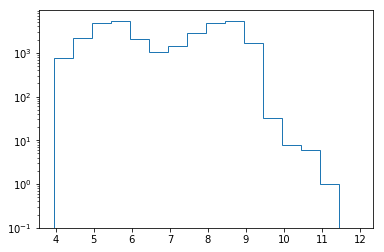

In [10]:
bins = bins = np.arange(min(tot), max(tot), 0.5)
num, bins, _ = plt.hist(tot, bins=bins, log=True, histtype='step')

In [13]:
bins.min()

3.951539415407902

In [1]:
from icecube import icetray, dataio, dataclasses, simclasses, clsim
from icecube.icetray import I3Units, OMKey, I3Frame
from icecube.dataclasses import ModuleKey
from os.path import expandvars
import scipy.constants as spc
import scipy as sc
import numpy as np
import matplotlib.pylab as plt
from scipy import stats
from scipy.optimize import minimize
from scipy.stats.distributions import chi2
import scipy
from likelihoodRatioAnalysis import likelihoodfit

#file = dataio.I3File(str(infile))

gcd_file = dataio.I3File('/home/users/akatil/P-ONE/GCD_files/PONE_Phase1.i3.gz')
cframe = gcd_file.pop_frame()
geometry = cframe["I3Geometry"]
omgeo = geometry.omgeo
print('loaded geometry')

tauLLR = ([])
eLLR = ([])
rejected = ([])
for i in range(90, 110):
    print(i)
    file = dataio.I3File('/data/p-one/akatil/step_4_medium_water/NuTau_NuE_20Events/step_4_'+str(i)+'_medium_water_custom_mDOM_noise.i3.gz')

    for frame in file:
        print('Starting')
        numHitsinDOM = ([])
        numHits = ([])
        mctree = frame["I3MCTree"]
        primary = mctree.primaries
        lepton = dataclasses.I3MCTree.first_child(mctree, primary[0].id)

        mcpeMap = frame['MCPESeriesMap']
        noiseMap = frame['NoiseSeriesMap']

        #looping through doms that have physics hits
        for omkey in mcpeMap.keys():
            oKey = omgeo.get(omkey)

            '''
            Obtaining the timeList
            '''
            noise_mcpeList = noiseMap[omkey]
            noise_timeList = np.array([mcpe.time for mcpe in noise_mcpeList])
            mcpeList = mcpeMap[omkey]
            timeList = np.array([mcpe.time for mcpe in mcpeList])
            tot_timeList = np.append(timeList, noise_timeList)
            numHitsinDOM = np.append(tot_timeList, noise_timeList)

            #print(numHitsinDOM)

        numHits = np.append(numHits, sum(numHitsinDOM))
        log_numHits = np.log10(numHits[numHits > 0])
        print(log_numHits)
        if log_numHits > 0 and log_numHits <= 100:
            val, string = likelihoodfit(frame, omgeo)
            if string == 'tau':
                tauLLR = np.append(tauLLR, val)
            if string == 'e':
                eLLR = np.append(eLLR, val)
            if string == 'rejected events':
                rejected = np.append(rejected, val)

np.savetxt('/data/p-one/akatil/analysis/NuTau_NuE_20Events_allCharge_2DelLLR' + '_tau.csv', tauLLR, delimiter=',')
np.savetxt('/data/p-one/akatil/analysis/NuTau_NuE_20Events_allCharge_2DelLLR' + '_e.csv', eLLR, delimiter=',')


loaded geometry
90
Starting
[5.95121996]
Likelihood fit function called
event rejected
Starting
[6.21525613]
Likelihood fit function called
event rejected
Starting
[6.32758395]
Likelihood fit function called


/cvmfs/icecube.opensciencegrid.org/py2-v3.1.1/RHEL_7_x86_64/lib/python2.7/site-packages/scipy/optimize/_minimize.py:394: RuntimeWarning: Method Powell cannot handle constraints nor bounds.
  RuntimeWarning)
likelihoodHelpers.py:58: RuntimeWarning: invalid value encountered in log
  L = model - (n*np.log(model))


Starting
[5.56483027]
Likelihood fit function called
event rejected
Starting
[6.23612422]
Likelihood fit function called
event rejected
Starting
[6.57303776]
Likelihood fit function called
event rejected
Starting
[5.83101325]
Likelihood fit function called
event rejected
Starting
[6.1133177]
Likelihood fit function called
event rejected
Starting
[8.66847186]
Likelihood fit function called
event rejected
Starting
[8.54285115]
Likelihood fit function called
event rejected
Starting
[5.99319844]
Likelihood fit function called
event rejected
Starting
[6.67184905]
Likelihood fit function called
event rejected
Starting
[5.91952361]
Likelihood fit function called


likelihoodHelpers.py:66: RuntimeWarning: invalid value encountered in log
  L = model - (n*np.log(model))


Starting
[8.80286253]
Likelihood fit function called
event rejected
91
Starting
[6.47994491]
Likelihood fit function called
event rejected
Starting
[5.78384673]
Likelihood fit function called
event rejected
Starting
[8.62681244]
Likelihood fit function called
event rejected
Starting
[7.39695435]
Likelihood fit function called
event rejected
Starting
[8.01609569]
Likelihood fit function called
event rejected
Starting
[5.62200475]
Likelihood fit function called
event rejected
Starting
[5.89090495]
Likelihood fit function called
event rejected
Starting
[8.66743339]
Likelihood fit function called
event rejected
Starting
[8.74877969]
Likelihood fit function called
event rejected
Starting
[5.5571355]
Likelihood fit function called
event rejected
Starting
[5.27848506]
Likelihood fit function called
event rejected
Starting
[8.52120219]
Likelihood fit function called
event rejected
Starting
[6.66330738]
Likelihood fit function called
event rejected
Starting
[8.85035514]
Likelihood fit function 

likelihoodHelpers.py:66: RuntimeWarning: divide by zero encountered in log
  L = model - (n*np.log(model))
/cvmfs/icecube.opensciencegrid.org/py2-v3.1.1/RHEL_7_x86_64/lib/python2.7/site-packages/scipy/optimize/optimize.py:1850: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


Starting
[4.90643346]
Likelihood fit function called
event rejected
Starting
[5.37080775]
Likelihood fit function called
event rejected
Starting
[5.10861253]
Likelihood fit function called
event rejected
Starting
[5.55224933]
Likelihood fit function called
event rejected
Starting
[7.77594062]
Likelihood fit function called


likelihoodHelpers.py:58: RuntimeWarning: divide by zero encountered in log
  L = model - (n*np.log(model))


Error in amp
Starting
[8.36758136]
Likelihood fit function called


likelihoodHelpers.py:58: RuntimeWarning: invalid value encountered in multiply
  L = model - (n*np.log(model))


Removing DOMs whose minimization is not successful
Starting
[7.2993069]
Likelihood fit function called
event rejected
Starting
[8.32907773]
Likelihood fit function called
Starting
[5.2705539]
Likelihood fit function called
event rejected
Starting
[4.77651317]
Likelihood fit function called
event rejected
Starting
[5.20009552]
Likelihood fit function called
event rejected
Starting
[8.04590036]
Likelihood fit function called
event rejected
Starting
[5.42622857]
Likelihood fit function called
event rejected
Starting
[8.10369259]
Likelihood fit function called
event rejected
93
Starting
[4.67018199]
Likelihood fit function called
event rejected
Starting
[4.95408114]
Likelihood fit function called
event rejected
Starting
[8.50440908]
Likelihood fit function called
event rejected
Starting
[8.12827172]
Likelihood fit function called
event rejected
Starting
[7.50534121]
Likelihood fit function called
Starting
[8.72428005]
Likelihood fit function called
event rejected
Starting
[5.28597338]
Like

likelihoodHelpers.py:66: RuntimeWarning: invalid value encountered in multiply
  L = model - (n*np.log(model))


Removing DOMs whose minimization is not successful
98
Starting
[5.52000317]
Likelihood fit function called
event rejected
Starting
[5.67757453]
Likelihood fit function called
event rejected
Starting
[5.56877156]
Likelihood fit function called
event rejected
Starting
[5.50706667]
Likelihood fit function called
event rejected
Starting
[8.64896464]
Likelihood fit function called
Starting
[5.43591861]
Likelihood fit function called
event rejected
Starting
[5.4686665]
Likelihood fit function called
Starting
[7.80017087]
Likelihood fit function called
event rejected
Starting
[8.14025936]
Likelihood fit function called
event rejected
Starting
[8.25631421]
Likelihood fit function called
Starting
[5.5066238]
Likelihood fit function called
event rejected
Starting
[9.01718872]
Likelihood fit function called
event rejected
Starting
[5.49921079]
Likelihood fit function called
event rejected
Starting
[8.82184458]
Likelihood fit function called
event rejected
Starting
[8.09885659]
Likelihood fit func

Starting
[6.21641266]
Likelihood fit function called
event rejected
Starting
[8.30432153]
Likelihood fit function called
event rejected
Starting
[6.141203]
Likelihood fit function called
Starting
[5.89269981]
Likelihood fit function called
event rejected
Starting
[6.13512614]
Likelihood fit function called
event rejected
Starting
[9.19373954]
Likelihood fit function called
event rejected
Starting
[6.0238101]
Likelihood fit function called
event rejected
106
Starting
[5.6994381]
Likelihood fit function called
Starting
[9.01847716]
Likelihood fit function called
event rejected
Starting
[5.57458706]
Likelihood fit function called
Starting
[8.7213933]
Likelihood fit function called
event rejected
Starting
[8.82619165]
Likelihood fit function called
event rejected
Starting
[5.72421841]
Likelihood fit function called
event rejected
Starting
[5.38555448]
Likelihood fit function called
event rejected
Starting
[5.51145954]
Likelihood fit function called
event rejected
Starting
[9.18328615]
Like

In [2]:
rejected.shape

(298,)

In [3]:
tauLLR.shape

(16,)

In [4]:
eLLR.shape

(22,)

(array([0.00723124, 0.00241041, 0.        , 0.0006026 , 0.00120521,
        0.0006026 , 0.0006026 , 0.        , 0.        , 0.0006026 ]),
 array([2.31763547e-03, 7.54325854e+01, 1.50862853e+02, 2.26293121e+02,
        3.01723389e+02, 3.77153656e+02, 4.52583924e+02, 5.28014192e+02,
        6.03444460e+02, 6.78874727e+02, 7.54304995e+02]),
 <a list of 10 Patch objects>)

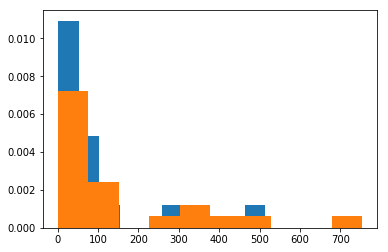

In [5]:
plt.hist(tauLLR, normed=True)
plt.hist(eLLR, normed=True)